In [1]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set(style="ticks", color_codes=True, font_scale=1.3);pd.set_option('max_columns',None)
import matplotlib.pyplot as plt
import re
import nltk
import warnings
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, f1_score, accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
nltk.download('inaugural')
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import inaugural,stopwords
inaugural.fileids()
from nltk.tokenize import sent_tokenize
import wordcloud
warnings.filterwarnings( "ignore")

[nltk_data] Downloading package inaugural to
[nltk_data]     C:\Users\vishw\AppData\Roaming\nltk_data...
[nltk_data]   Package inaugural is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vishw\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vishw\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
elect=pd.read_excel('Election_Data.xlsx',sheet_name='Election_Dataset_Two Classes')
elect.head()

,Unnamed: 0,vote,age,economic.cond.national,economic.cond.household,Blair,Hague,Europe,political.knowledge,gender
0,1,Labour,43,3,3,4,1,2,2,female
1,2,Labour,36,4,4,4,4,5,2,male
2,3,Labour,35,4,4,5,2,3,2,male
3,4,Labour,24,4,2,2,1,4,0,female
4,5,Labour,41,2,2,1,1,6,2,male


In [3]:
elect.drop("Unnamed: 0",axis=1,inplace=True)
elect.shape

(1525, 9)

In [4]:
elect.head()

,vote,age,economic.cond.national,economic.cond.household,Blair,Hague,Europe,political.knowledge,gender
0,Labour,43,3,3,4,1,2,2,female
1,Labour,36,4,4,4,4,5,2,male
2,Labour,35,4,4,5,2,3,2,male
3,Labour,24,4,2,2,1,4,0,female
4,Labour,41,2,2,1,1,6,2,male


In [5]:
elect.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1525 entries, 0 to 1524
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   vote                     1525 non-null   object
 1   age                      1525 non-null   int64 
 2   economic.cond.national   1525 non-null   int64 
 3   economic.cond.household  1525 non-null   int64 
 4   Blair                    1525 non-null   int64 
 5   Hague                    1525 non-null   int64 
 6   Europe                   1525 non-null   int64 
 7   political.knowledge      1525 non-null   int64 
 8   gender                   1525 non-null   object
dtypes: int64(7), object(2)
memory usage: 107.4+ KB


In [6]:
elect.isnull().sum()

vote                       0
age                        0
economic.cond.national     0
economic.cond.household    0
Blair                      0
Hague                      0
Europe                     0
political.knowledge        0
gender                     0
dtype: int64

In [7]:
elect_duplicates=elect[elect.duplicated()]
elect_duplicates

,vote,age,economic.cond.national,economic.cond.household,Blair,Hague,Europe,political.knowledge,gender
67,Labour,35,4,4,5,2,3,2,male
626,Labour,39,3,4,4,2,5,2,male
870,Labour,38,2,4,2,2,4,3,male
983,Conservative,74,4,3,2,4,8,2,female
1154,Conservative,53,3,4,2,2,6,0,female
1236,Labour,36,3,3,2,2,6,2,female
1244,Labour,29,4,4,4,2,2,2,female
1438,Labour,40,4,3,4,2,2,2,male


In [8]:
elect.drop_duplicates(keep='first',inplace=True)

In [9]:
elect.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1517.0,54.241266,15.701741,24.0,41.0,53.0,67.0,93.0
economic.cond.national,1517.0,3.245221,0.881792,1.0,3.0,3.0,4.0,5.0
economic.cond.household,1517.0,3.137772,0.931069,1.0,3.0,3.0,4.0,5.0
Blair,1517.0,3.335531,1.174772,1.0,2.0,4.0,4.0,5.0
Hague,1517.0,2.749506,1.232479,1.0,2.0,2.0,4.0,5.0
Europe,1517.0,6.740277,3.299043,1.0,4.0,6.0,10.0,11.0
political.knowledge,1517.0,1.540541,1.084417,0.0,0.0,2.0,2.0,3.0


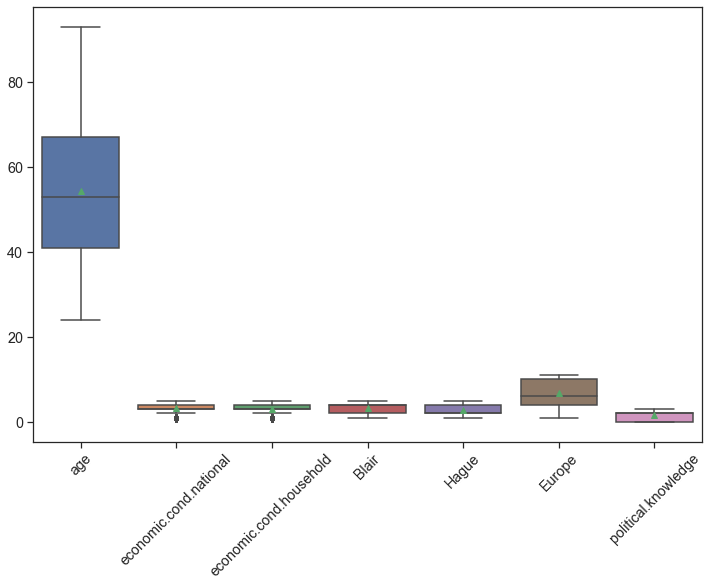

In [10]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=elect,showmeans=True)
plt.xticks(rotation=45);

In [11]:
def univariateAnalysis_numeric(column,nbins):
    print("Description of " + column)
    print("----------------------------------------------------------------------------")
    print(elect[column].describe(),end=' ')
    
    print('\n')
    print("Skewness of " + column)
    print("----------------------------------------------------------------------------")
    print(round (elect[column].skew(skipna=True),2),end=' ')    
    plt.figure()
    mean = elect[column].mean()
    median = elect[column].median()
    print("Distribution of " + column)
    print("----------------------------------------------------------------------------")
    sns.histplot(elect[column], kde=False, color='g')
    plt.axvline(mean, color='r', linestyle='--')
    plt.axvline(median, color='b', linestyle='--');
    plt.show()
    
    plt.figure()
    print("BoxPlot of " + column)
    print("----------------------------------------------------------------------------")
    ax = sns.boxplot(x=elect[column],showmeans=True)
    plt.show()

In [12]:
cat=[]
num=[]
for i in elect.columns:
    if elect[i].dtype=="object":
        cat.append(i)
    else:
        num.append(i)
print(cat) 
print(num)

['vote', 'gender']
['age', 'economic.cond.national', 'economic.cond.household', 'Blair', 'Hague', 'Europe', 'political.knowledge']


Description of age
----------------------------------------------------------------------------
count    1517.000000
mean       54.241266
std        15.701741
min        24.000000
25%        41.000000
50%        53.000000
75%        67.000000
max        93.000000
Name: age, dtype: float64 

Skewness of age
----------------------------------------------------------------------------
0.14 Distribution of age
----------------------------------------------------------------------------


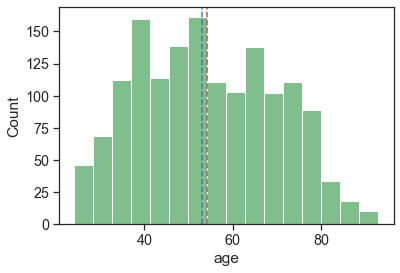

BoxPlot of age
----------------------------------------------------------------------------


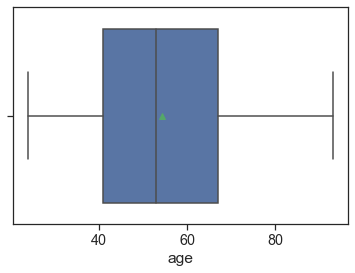

Description of economic.cond.national
----------------------------------------------------------------------------
count    1517.000000
mean        3.245221
std         0.881792
min         1.000000
25%         3.000000
50%         3.000000
75%         4.000000
max         5.000000
Name: economic.cond.national, dtype: float64 

Skewness of economic.cond.national
----------------------------------------------------------------------------
-0.24 Distribution of economic.cond.national
----------------------------------------------------------------------------


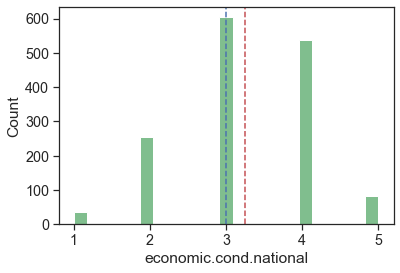

BoxPlot of economic.cond.national
----------------------------------------------------------------------------


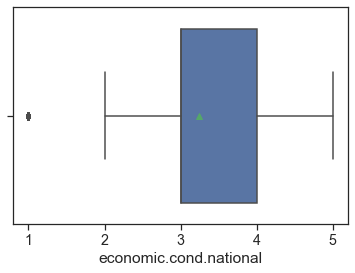

Description of economic.cond.household
----------------------------------------------------------------------------
count    1517.000000
mean        3.137772
std         0.931069
min         1.000000
25%         3.000000
50%         3.000000
75%         4.000000
max         5.000000
Name: economic.cond.household, dtype: float64 

Skewness of economic.cond.household
----------------------------------------------------------------------------
-0.14 Distribution of economic.cond.household
----------------------------------------------------------------------------


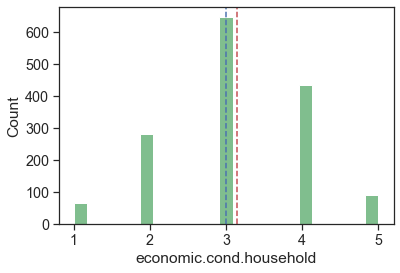

BoxPlot of economic.cond.household
----------------------------------------------------------------------------


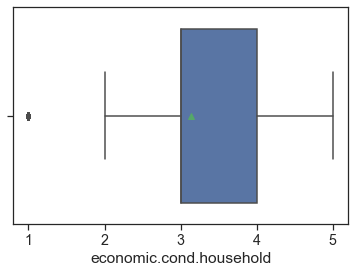

Description of Blair
----------------------------------------------------------------------------
count    1517.000000
mean        3.335531
std         1.174772
min         1.000000
25%         2.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: Blair, dtype: float64 

Skewness of Blair
----------------------------------------------------------------------------
-0.54 Distribution of Blair
----------------------------------------------------------------------------


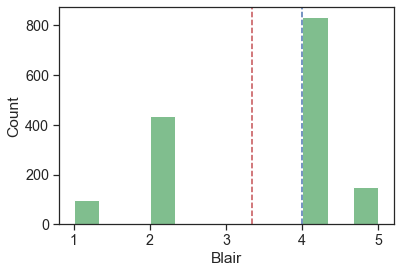

BoxPlot of Blair
----------------------------------------------------------------------------


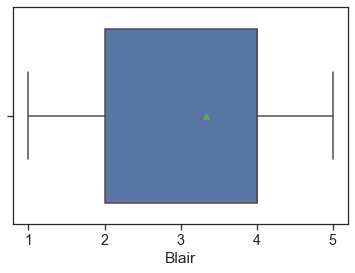

Description of Hague
----------------------------------------------------------------------------
count    1517.000000
mean        2.749506
std         1.232479
min         1.000000
25%         2.000000
50%         2.000000
75%         4.000000
max         5.000000
Name: Hague, dtype: float64 

Skewness of Hague
----------------------------------------------------------------------------
0.15 Distribution of Hague
----------------------------------------------------------------------------


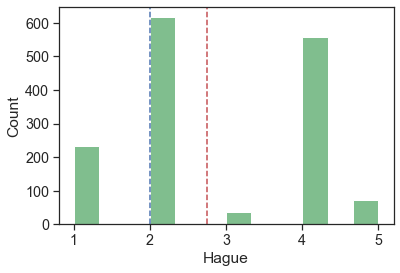

BoxPlot of Hague
----------------------------------------------------------------------------


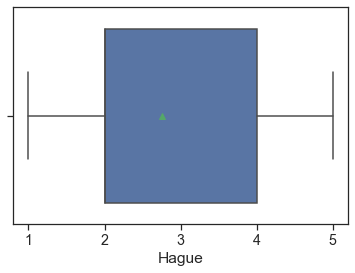

Description of Europe
----------------------------------------------------------------------------
count    1517.000000
mean        6.740277
std         3.299043
min         1.000000
25%         4.000000
50%         6.000000
75%        10.000000
max        11.000000
Name: Europe, dtype: float64 

Skewness of Europe
----------------------------------------------------------------------------
-0.14 Distribution of Europe
----------------------------------------------------------------------------


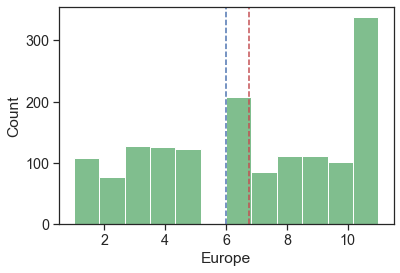

BoxPlot of Europe
----------------------------------------------------------------------------


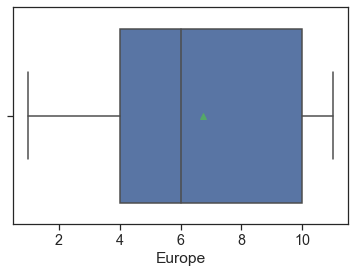

Description of political.knowledge
----------------------------------------------------------------------------
count    1517.000000
mean        1.540541
std         1.084417
min         0.000000
25%         0.000000
50%         2.000000
75%         2.000000
max         3.000000
Name: political.knowledge, dtype: float64 

Skewness of political.knowledge
----------------------------------------------------------------------------
-0.42 Distribution of political.knowledge
----------------------------------------------------------------------------


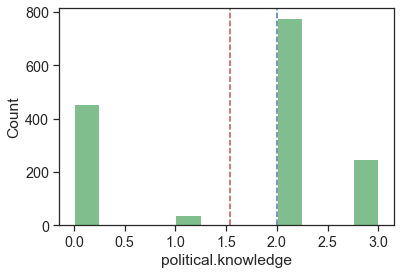

BoxPlot of political.knowledge
----------------------------------------------------------------------------


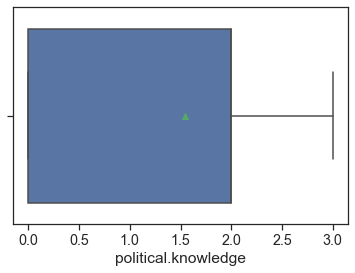

In [13]:
for x in num:
    univariateAnalysis_numeric(x,50)

Labour          0.69677
Conservative    0.30323
Name: vote, dtype: float64


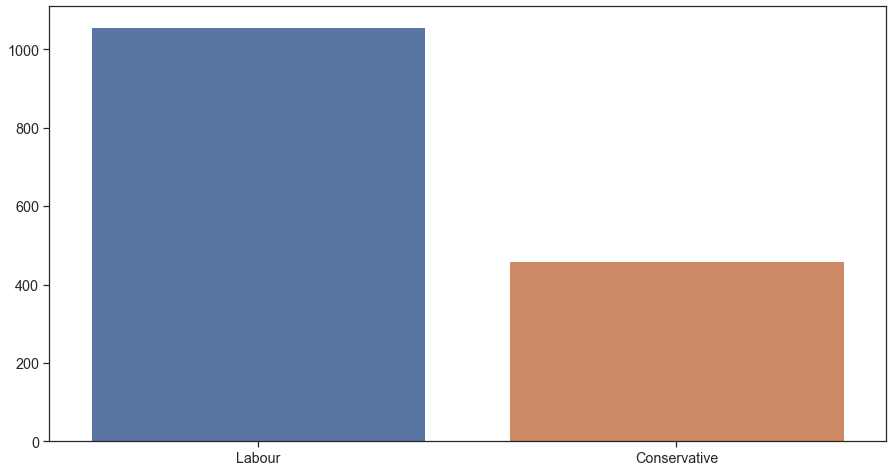

In [14]:
plt.figure(figsize=(15,8))
sns.barplot(elect.vote.value_counts().index,elect.vote.value_counts().values);
print(elect.vote.value_counts(normalize=True));

3    0.398154
4    0.354647
2    0.168754
5    0.054054
1    0.024390
Name: economic.cond.national, dtype: float64


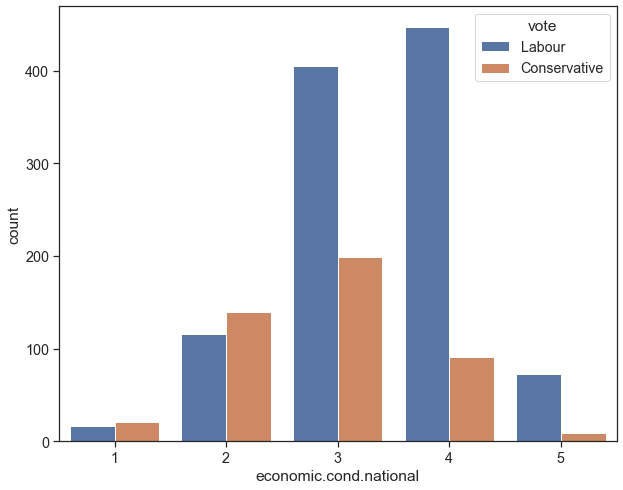

In [15]:
plt.figure(figsize=(10,8))
sns.countplot(x='economic.cond.national',data=elect,hue='vote')
print(elect['economic.cond.national'].value_counts(normalize=True));

3    0.425181
4    0.286750
2    0.184575
5    0.060646
1    0.042848
Name: economic.cond.household, dtype: float64


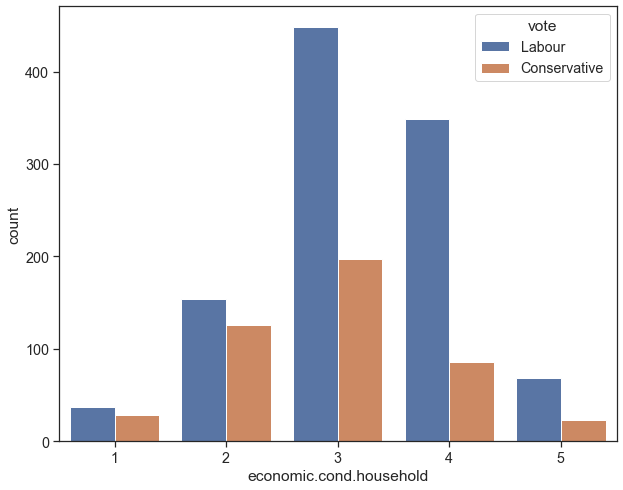

In [16]:
plt.figure(figsize=(10,8))
sns.countplot(x='economic.cond.household',data=elect,hue='vote')
print(elect['economic.cond.household'].value_counts(normalize=True));

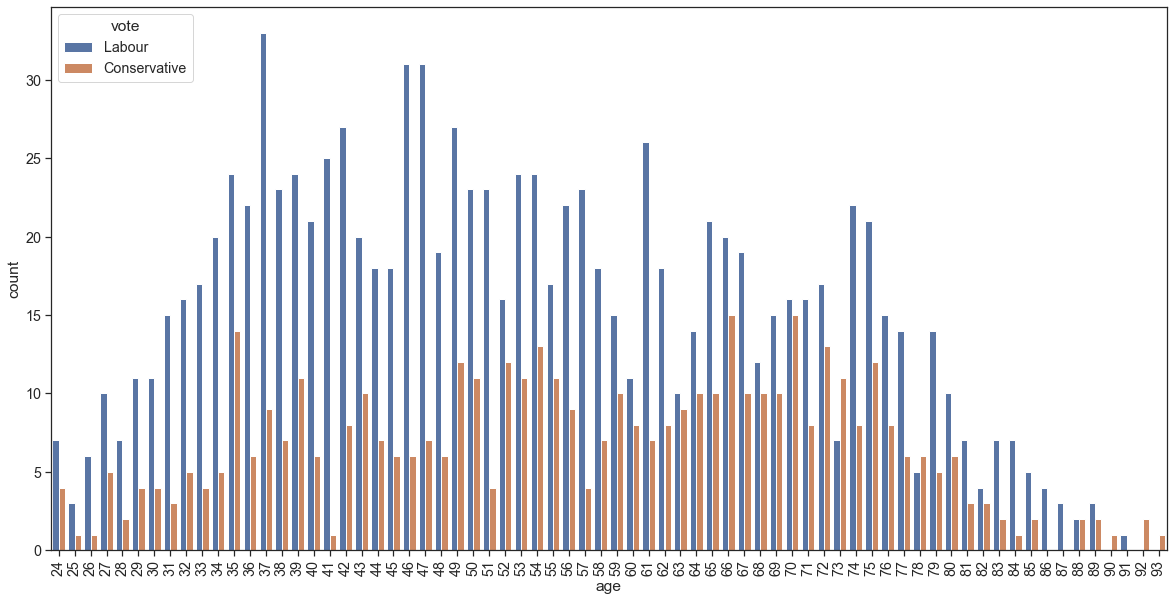

In [17]:
plt.figure(figsize=(20,10))
sns.countplot(x='age',data=elect,hue='vote')
plt.xticks(rotation=90);

female    0.53263
male      0.46737
Name: gender, dtype: float64


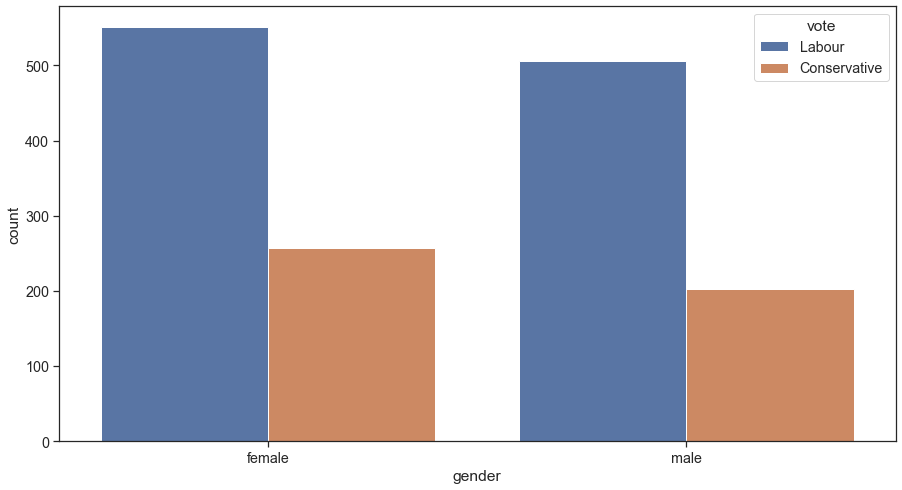

In [18]:
plt.figure(figsize=(15,8))
sns.countplot(x='gender',data=elect,hue='vote')
print(elect.gender.value_counts(normalize=True));

4    0.549110
2    0.286091
5    0.100198
1    0.063942
3    0.000659
Name: Blair, dtype: float64


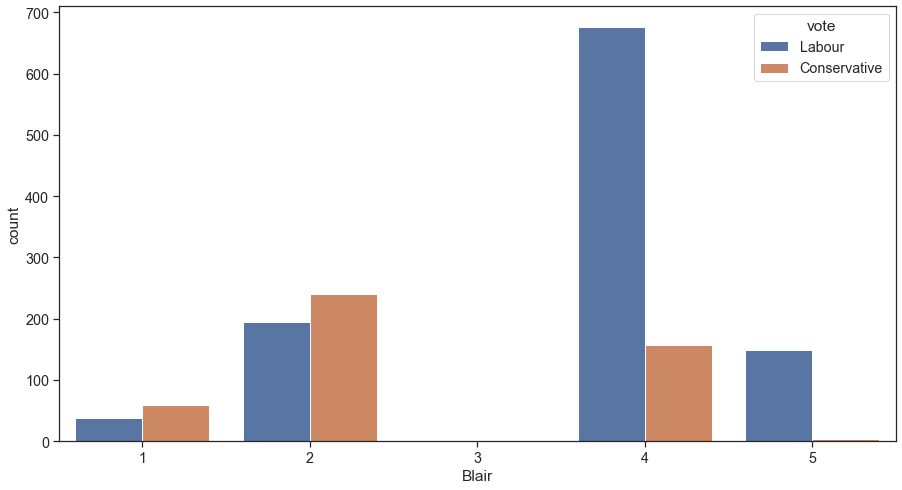

In [19]:
plt.figure(figsize=(15,8))
sns.countplot(x='Blair',data=elect,hue='vote')
print(elect.Blair.value_counts(normalize=True));

2    0.406724
4    0.367172
1    0.153593
5    0.048121
3    0.024390
Name: Hague, dtype: float64


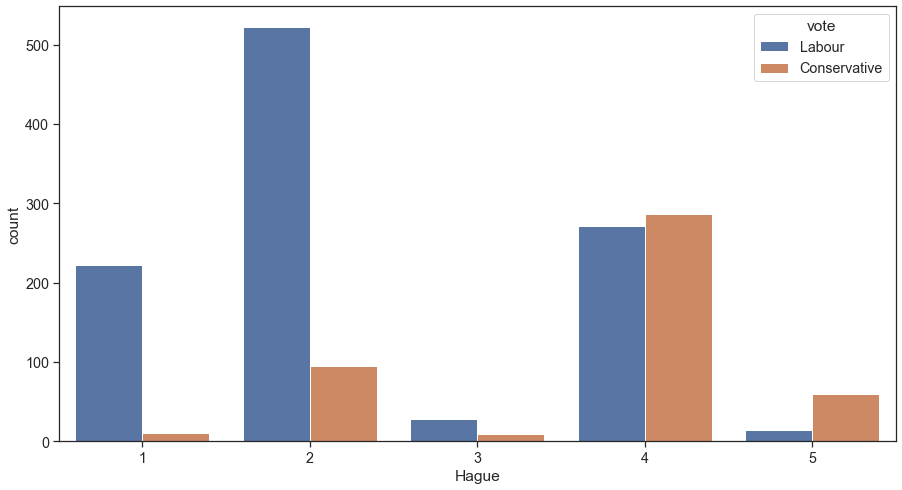

In [20]:
plt.figure(figsize=(15,8))
sns.countplot(x='Hague',data=elect,hue='vote')
print(elect.Hague.value_counts(normalize=True));

11    0.222808
6     0.136454
3     0.084377
4     0.083059
5     0.081081
9     0.073171
8     0.073171
1     0.071852
10    0.066579
7     0.056691
2     0.050758
Name: Europe, dtype: float64


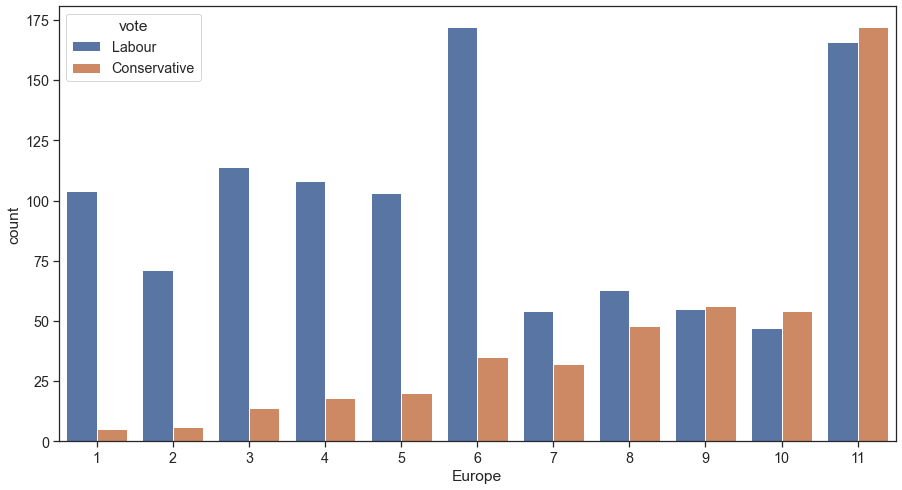

In [21]:
plt.figure(figsize=(15,8))
sns.countplot(x='Europe',data=elect,hue='vote')
print(elect.Europe.value_counts(normalize=True));

In [22]:
elect.corr()

,age,economic.cond.national,economic.cond.household,Blair,Hague,Europe,political.knowledge
age,1.000000,0.018687,-0.038868,0.032084,0.031144,0.064562,-0.046598
economic.cond.national,0.018687,1.000000,0.347687,0.326141,-0.200790,-0.209150,-0.023510
economic.cond.household,-0.038868,0.347687,1.000000,0.215822,-0.100392,-0.112897,-0.038528
Blair,0.032084,0.326141,0.215822,1.000000,-0.243508,-0.295944,-0.021299
Hague,0.031144,-0.200790,-0.100392,-0.243508,1.000000,0.285738,-0.029906
Europe,0.064562,-0.209150,-0.112897,-0.295944,0.285738,1.000000,-0.151197
political.knowledge,-0.046598,-0.023510,-0.038528,-0.021299,-0.029906,-0.151197,1.000000


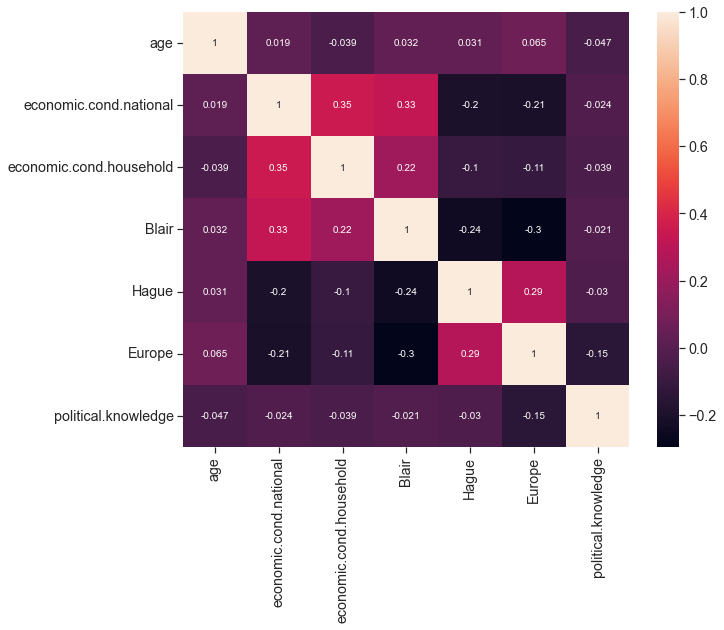

In [23]:
plt.figure(figsize=(10,8))
sns.heatmap(elect.corr(),annot=True)
plt.show()

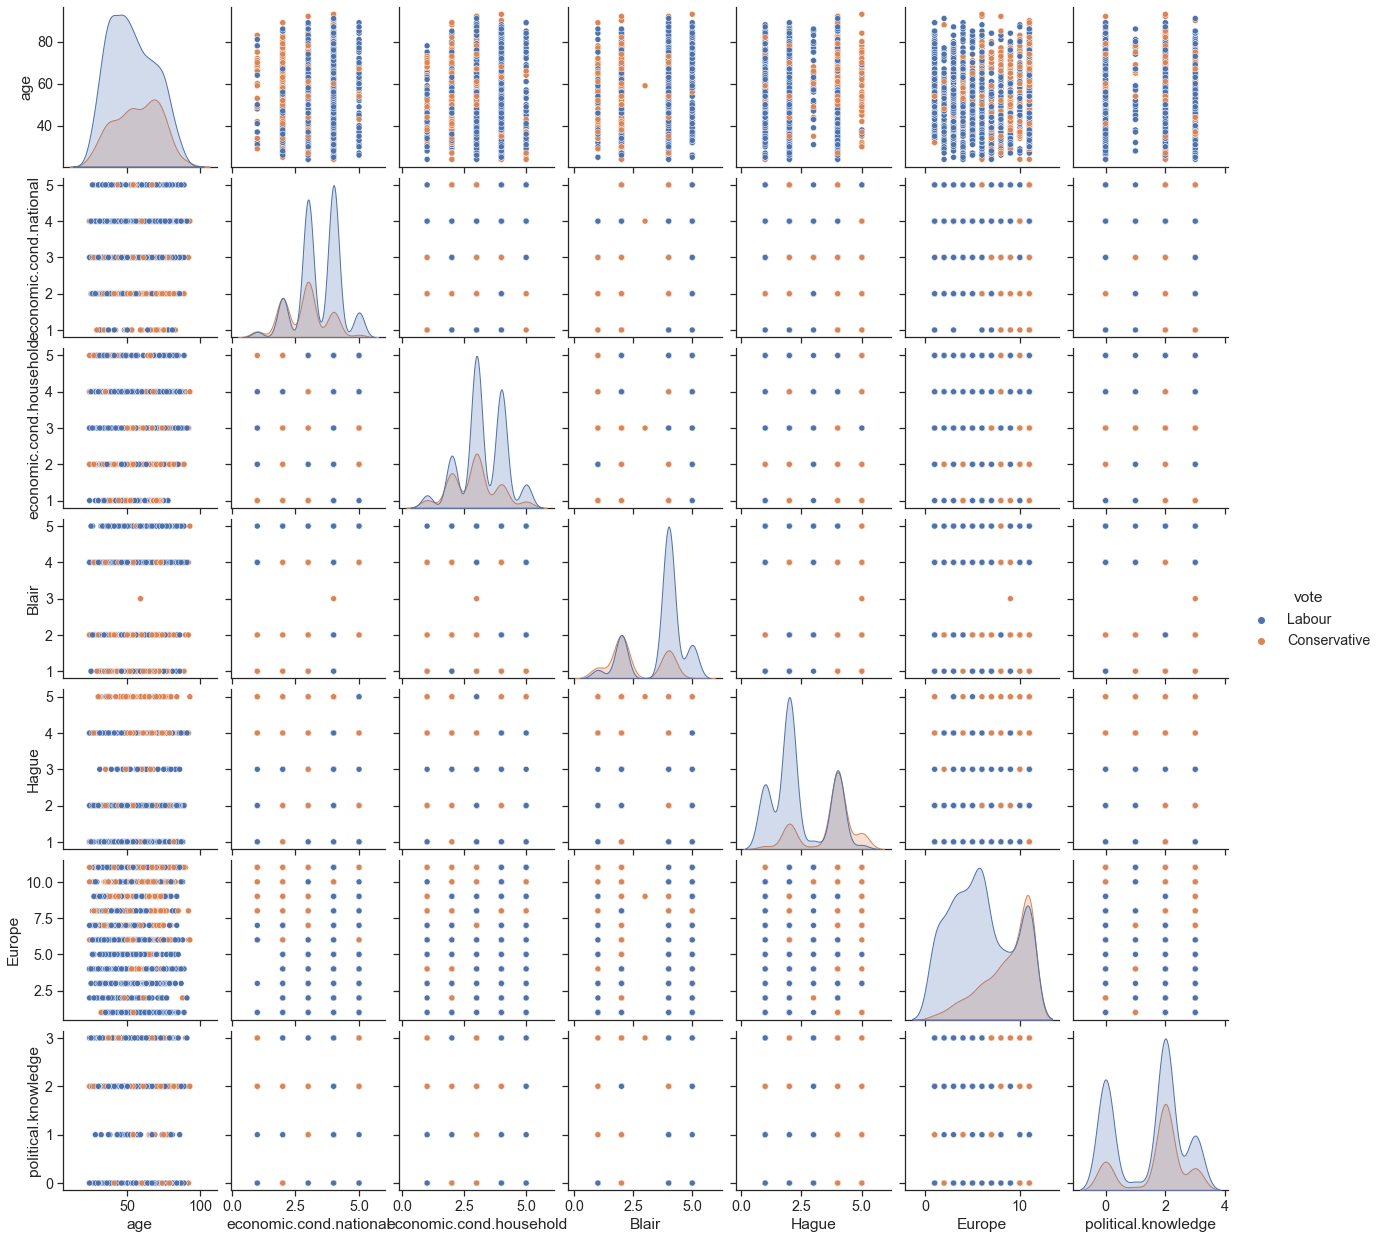

In [24]:
sns.pairplot(elect,hue='vote',diag_kind='kde');

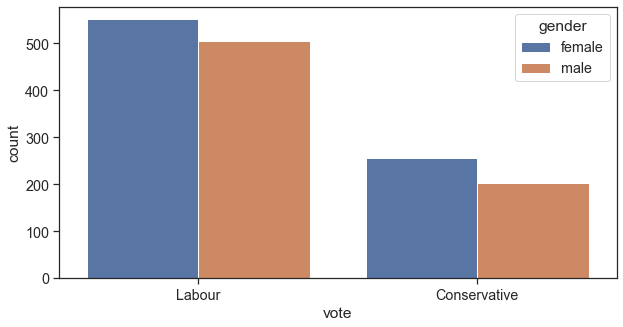

In [25]:
plt.figure(figsize=(10,5))
sns.countplot(x='vote',data=elect,hue='gender');

<AxesSubplot:xlabel='vote', ylabel='count'>

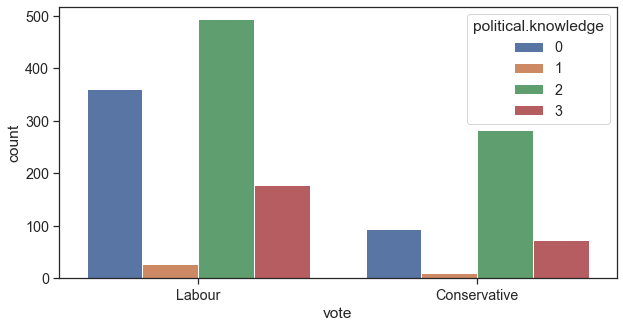

In [26]:
plt.figure(figsize=(10,5))
sns.countplot(x='vote',data=elect,hue='political.knowledge')

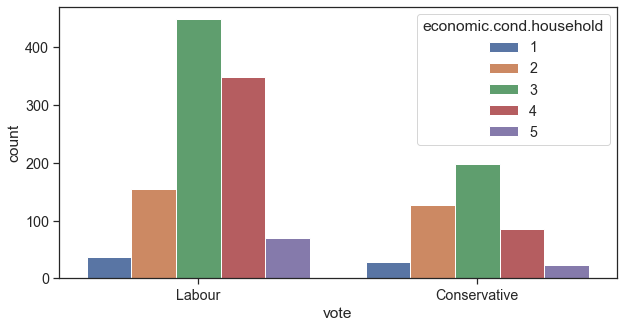

In [27]:
plt.figure(figsize=(10,5))
sns.countplot(x='vote',data=elect,hue='economic.cond.household');

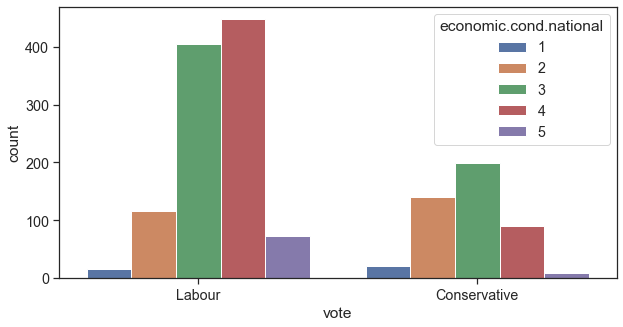

In [28]:
plt.figure(figsize=(10,5))
sns.countplot(x='vote',data=elect,hue='economic.cond.national');

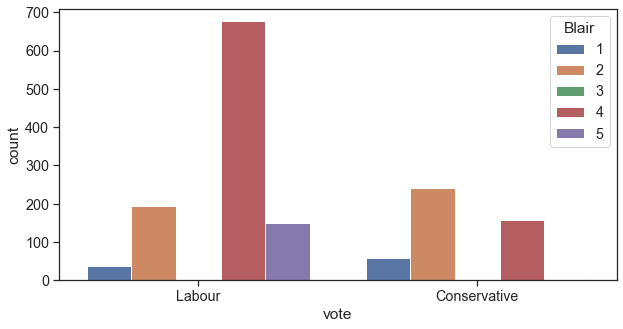

In [29]:
plt.figure(figsize=(10,5))
sns.countplot(x='vote',data=elect,hue='Blair');

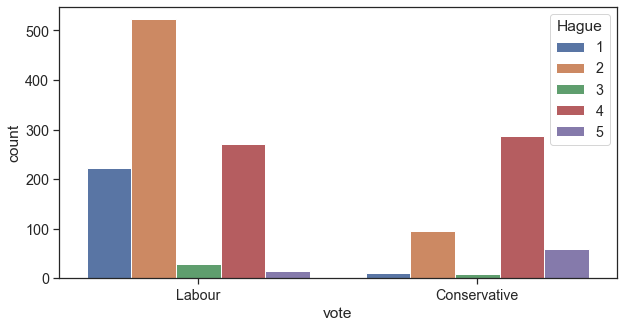

In [30]:
plt.figure(figsize=(10,5))
sns.countplot(x='vote',data=elect,hue='Hague');

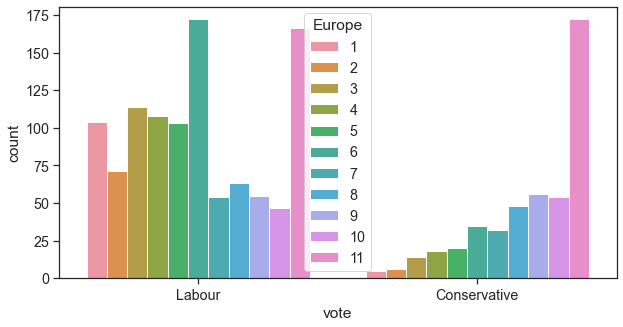

In [31]:
plt.figure(figsize=(10,5))
sns.countplot(x='vote',data=elect,hue='Europe');

In [32]:
for feature in elect.columns: 
    if elect[feature].dtype == 'object': 
        print('\n')
        print('feature:',feature)
        print(pd.Categorical(elect[feature].unique()))
        print(pd.Categorical(elect[feature].unique()).codes)
        elect[feature] = pd.Categorical(elect[feature]).codes



feature: vote
['Labour', 'Conservative']
Categories (2, object): ['Conservative', 'Labour']
[1 0]


feature: gender
['female', 'male']
Categories (2, object): ['female', 'male']
[0 1]


In [33]:
elect.head()

,vote,age,economic.cond.national,economic.cond.household,Blair,Hague,Europe,political.knowledge,gender
0,1,43,3,3,4,1,2,2,0
1,1,36,4,4,4,4,5,2,1
2,1,35,4,4,5,2,3,2,1
3,1,24,4,2,2,1,4,0,0
4,1,41,2,2,1,1,6,2,1


In [34]:
sc=StandardScaler()

In [35]:
elect['age']=sc.fit_transform(elect[['age']])
elect['economic.cond.national']=sc.fit_transform(elect[['economic.cond.national']])
elect['economic.cond.household']=sc.fit_transform(elect[['economic.cond.household']])
elect['Blair']=sc.fit_transform(elect[['Blair']])
elect['Hague']=sc.fit_transform(elect[['Hague']])
elect['Europe']=sc.fit_transform(elect[['Europe']])
elect['political.knowledge']=sc.fit_transform(elect[['political.knowledge']])
elect['gender']=sc.fit_transform(elect[['gender']])

In [36]:
elect.describe().T

,count,mean,std,min,25%,50%,75%,max
vote,1517.0,6.967699e-01,0.459805,0.000000,0.000000,1.000000,1.000000,1.000000
age,1517.0,1.917458e-17,1.000330,-1.926617,-0.843577,-0.079079,0.812836,2.469250
economic.cond.national,1517.0,-1.984789e-16,1.000330,-2.547041,-0.278185,-0.278185,0.856242,1.990670
economic.cond.household,1517.0,-2.397189e-16,1.000330,-2.296796,-0.148020,-0.148020,0.926367,2.000755
Blair,1517.0,-1.034842e-16,1.000330,-1.988727,-1.137217,0.565802,0.565802,1.417312
Hague,1517.0,5.386448e-17,1.000330,-1.419969,-0.608329,-0.608329,1.014951,1.826592
Europe,1517.0,6.293947e-17,1.000330,-1.740556,-0.830902,-0.224465,0.988407,1.291625
political.knowledge,1517.0,-7.665442e-16,1.000330,-1.421084,-1.421084,0.423832,0.423832,1.346290
gender,1517.0,2.648581e-16,1.000330,-0.936736,-0.936736,-0.936736,1.067536,1.067536


In [37]:
X=elect.drop('vote',axis=1)
y=elect.pop('vote')

In [38]:
x_train,x_test,train_labels,test_labels=train_test_split(X,y,test_size=0.30,random_state=1)

In [39]:
print("X_train",x_train.shape)
print("X_test",x_test.shape)
print("train_labels",train_labels.shape)
print("test_labels",test_labels.shape)

X_train (1061, 8)
X_test (456, 8)
train_labels (1061,)
test_labels (456,)


# LOGISTIC REGRESSION MODEL

In [40]:
lm=LogisticRegression(solver='newton-cg',max_iter=10000,penalty='none',verbose=True,n_jobs=2,random_state=123)
lm.fit(x_train,train_labels)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    2.5s finished


LogisticRegression(max_iter=10000, n_jobs=2, penalty='none', random_state=123,
                   solver='newton-cg', verbose=True)

In [41]:
lmtrain_predict = lm.predict(x_train)
lmtest_predict = lm.predict(x_test)

In [42]:
lmtest_predict_prob=lm.predict_proba(x_test)
pd.DataFrame(lmtest_predict_prob).head()

,0,1
0,0.424284,0.575716
1,0.148426,0.851574
2,0.007187,0.992813
3,0.836350,0.163650
4,0.068407,0.931593


In [43]:
print('Training data score',format(lm.score(x_train, train_labels)))
print('Testing data score',format(lm.score(x_test, test_labels)))

Training data score 0.8312912346842601
Testing data score 0.8355263157894737


Accuracy for Logistics Regression Model is 

 0.8312912346842601


Classification report for Logistics Regression Model Training Data is 
               precision    recall  f1-score   support

           0       0.74      0.64      0.69       307
           1       0.86      0.91      0.88       754

    accuracy                           0.83      1061
   macro avg       0.80      0.77      0.79      1061
weighted avg       0.83      0.83      0.83      1061





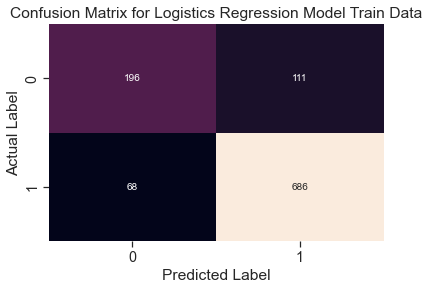

In [44]:
models_names={lm:'Logistics Regression Model'}

print('Accuracy for {} is'.format(models_names[lm]),'\n\n',accuracy_score(train_labels,lmtrain_predict))
print('\n')
print('Classification report for {} Training Data is'.format(models_names[lm]),'\n',
      classification_report(train_labels,lmtrain_predict))
print('\n')
sns.heatmap(confusion_matrix(train_labels,lmtrain_predict),annot=True,fmt='d',cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title("Confusion Matrix for {} Train Data".format(models_names[lm]))
plt.show()

Accuracy for Logistics Regression Model is 

 0.8355263157894737


Classification report for Logistics Regression Model Testing Data is 
               precision    recall  f1-score   support

           0       0.76      0.74      0.75       153
           1       0.87      0.88      0.88       303

    accuracy                           0.84       456
   macro avg       0.82      0.81      0.81       456
weighted avg       0.83      0.84      0.83       456





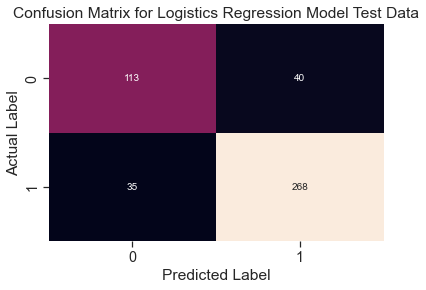

In [45]:
models_names={lm:'Logistics Regression Model'}

print('Accuracy for {} is'.format(models_names[lm]),'\n\n',accuracy_score(test_labels,lmtest_predict))
print('\n')
print('Classification report for {} Testing Data is'.format(models_names[lm]),'\n',
      classification_report(test_labels,lmtest_predict))
print('\n')
sns.heatmap(confusion_matrix(test_labels,lmtest_predict),annot=True,fmt='d',cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title("Confusion Matrix for {} Test Data".format(models_names[lm]))
plt.show()

AUC for the Training Data: 0.890
AUC for the Test Data: 0.883


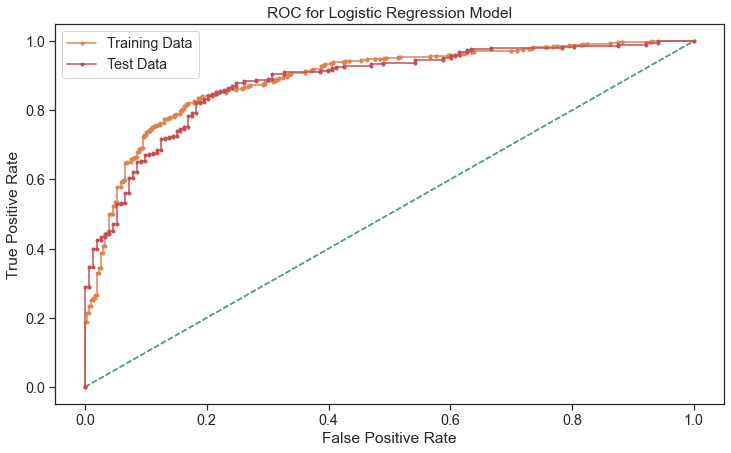

In [46]:
# AUC and ROC for the training data
plt.figure(figsize=(12,7))
# calculate AUC
auc = roc_auc_score(train_labels,lm.predict_proba(x_train)[:,1])
print('AUC for the Training Data: %.3f' % auc)

#  calculate roc curve
fpr, tpr, thresholds = roc_curve(train_labels,lm.predict_proba(x_train)[:,1])
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.',label = 'Training Data')

# AUC and ROC for the test data

# calculate AUC
auc = roc_auc_score(test_labels,lm.predict_proba(x_test)[:,1])
print('AUC for the Test Data: %.3f' % auc)

#  calculate roc curve
fpr, tpr, thresholds = roc_curve(test_labels,lm.predict_proba(x_test)[:,1])
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.',label='Test Data')
# show the plot
plt.legend(loc='best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Logistic Regression Model')
plt.show()

## LINEAR DISCRIMINANT ANALYSIS

In [47]:
clf=LinearDiscriminantAnalysis()
lda=clf.fit(x_train,train_labels)

In [48]:
# Training Data Class Prediction with a cut-off value of 0.5
pred_class_train = lda.predict(x_train)

# Test Data Class Prediction with a cut-off value of 0.5
pred_class_test = lda.predict(x_test)

In [49]:
print('Training data score',format(lda.score(x_train, train_labels)))
print('Testing data score',format(lda.score(x_test, test_labels)))

Training data score 0.8341187558906692
Testing data score 0.8333333333333334


Accuracy for Linear Discriminant Analysis is 

 0.8341187558906692


Classification report for Linear Discriminant Analysis Training Data is 
               precision    recall  f1-score   support

           0       0.74      0.65      0.69       307
           1       0.86      0.91      0.89       754

    accuracy                           0.83      1061
   macro avg       0.80      0.78      0.79      1061
weighted avg       0.83      0.83      0.83      1061





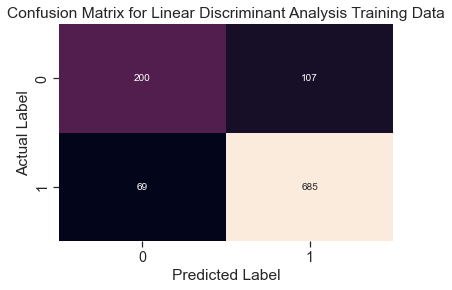

In [50]:
## Confusion matrix on the training data
models_names={lm:'Logistics Regression Model',lda:'Linear Discriminant Analysis'}

print('Accuracy for {} is'.format(models_names[lda]),'\n\n',accuracy_score(train_labels,pred_class_train))
print('\n')
print('Classification report for {} Training Data is'.format(models_names[lda]),'\n',
      classification_report(train_labels,pred_class_train))
print('\n')
sns.heatmap(confusion_matrix(train_labels,pred_class_train),annot=True,fmt='d',cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title("Confusion Matrix for {} Training Data".format(models_names[lda]))
plt.show()

Accuracy for Linear Discriminant Analysis is 

 0.8333333333333334


Classification report for Linear Discriminant Analysis Testing Data is 
               precision    recall  f1-score   support

           0       0.77      0.73      0.74       153
           1       0.86      0.89      0.88       303

    accuracy                           0.83       456
   macro avg       0.82      0.81      0.81       456
weighted avg       0.83      0.83      0.83       456





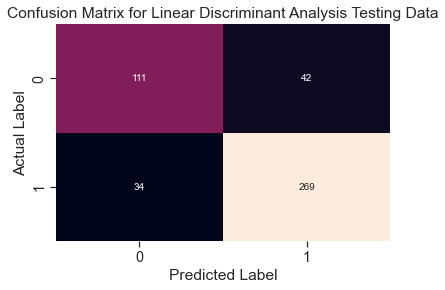

In [51]:
## Confusion matrix on the testing data
models_names={lm:'Logistics Regression Model',lda:'Linear Discriminant Analysis'}

print('Accuracy for {} is'.format(models_names[lda]),'\n\n',accuracy_score(test_labels,pred_class_test))
print('\n')
print('Classification report for {} Testing Data is'.format(models_names[lda]),'\n',
      classification_report(test_labels,pred_class_test))
print('\n')
sns.heatmap(confusion_matrix(test_labels,pred_class_test),annot=True,fmt='d',cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title("Confusion Matrix for {} Testing Data".format(models_names[lda]))
plt.show()

In [52]:
# Training Data Probability Prediction
pred_prob_train = lda.predict_proba(x_train)

# Test Data Probability Prediction
pred_prob_test = lda.predict_proba(x_test)

AUC for the Training Data: 0.889
AUC for the Test Data: 0.888


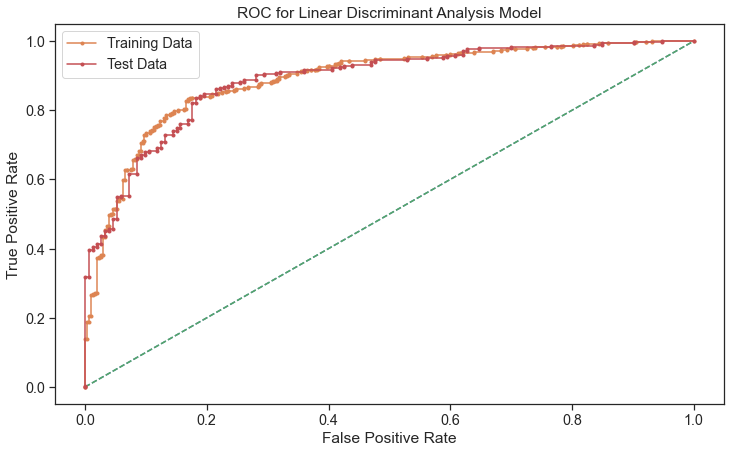

In [53]:
# AUC and ROC for the training data
plt.figure(figsize=(12,7))
# calculate AUC
auc = roc_auc_score(train_labels,pred_prob_train[:,1])
print('AUC for the Training Data: %.3f' % auc)

#  calculate roc curve
fpr, tpr, thresholds = roc_curve(train_labels,pred_prob_train[:,1])
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.',label = 'Training Data')

# AUC and ROC for the test data

# calculate AUC
auc = roc_auc_score(test_labels,pred_prob_test[:,1])
print('AUC for the Test Data: %.3f' % auc)

#  calculate roc curve
fpr, tpr, thresholds = roc_curve(test_labels,pred_prob_test[:,1])
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.',label='Test Data')
# show the plot
plt.legend(loc='best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Linear Discriminant Analysis Model')
plt.show()

# KNEAREST NEIGHBOUR MODEL

In [54]:
KNN_model=KNeighborsClassifier()
KNN_model.fit(x_train,train_labels)

KNeighborsClassifier()

In [55]:
knn_train_predict = KNN_model.predict(x_train)
knn_test_predict = KNN_model.predict(x_test)

In [56]:
knn_test_predict_prob=KNN_model.predict_proba(x_test)
pd.DataFrame(knn_test_predict_prob).head()

,0,1
0,1.0,0.0
1,0.0,1.0
2,0.0,1.0
3,0.8,0.2
4,0.0,1.0


In [57]:
print('Training data score for KNN Model',format(KNN_model.score(x_train, train_labels)))
print('Testing data score for KNN Model',format(KNN_model.score(x_test, test_labels)))

Training data score for KNN Model 0.8557964184731386
Testing data score for KNN Model 0.8245614035087719


Accuracy for KNearest Neighbour Model is 

 0.8557964184731386


Classification report for KNearest Neighbour Model Training Data is 
               precision    recall  f1-score   support

           0       0.77      0.71      0.74       307
           1       0.89      0.92      0.90       754

    accuracy                           0.86      1061
   macro avg       0.83      0.81      0.82      1061
weighted avg       0.85      0.86      0.85      1061





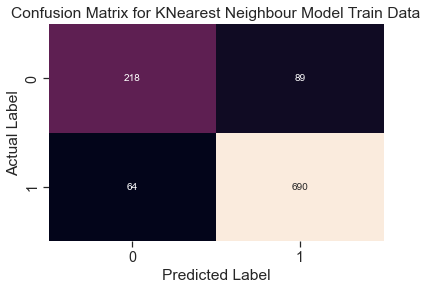

In [58]:
models_names={KNN_model:'KNearest Neighbour Model'}

print('Accuracy for {} is'.format(models_names[KNN_model]),'\n\n',accuracy_score(train_labels,knn_train_predict))
print('\n')
print('Classification report for {} Training Data is'.format(models_names[KNN_model]),'\n',
      classification_report(train_labels,knn_train_predict))
print('\n')
sns.heatmap(confusion_matrix(train_labels,knn_train_predict),annot=True,fmt='d',cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title("Confusion Matrix for {} Train Data".format(models_names[KNN_model]))
plt.show()

Accuracy for KNearest Neighbour Model is 

 0.8245614035087719


Classification report for KNearest Neighbour Model Testing Data is 
               precision    recall  f1-score   support

           0       0.77      0.69      0.72       153
           1       0.85      0.89      0.87       303

    accuracy                           0.82       456
   macro avg       0.81      0.79      0.80       456
weighted avg       0.82      0.82      0.82       456





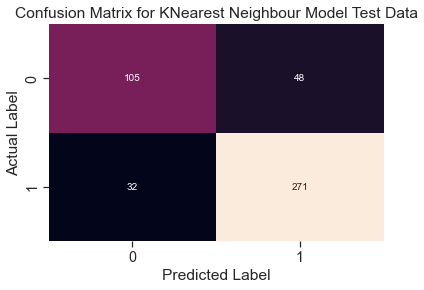

In [59]:
models_names={KNN_model:'KNearest Neighbour Model'}

print('Accuracy for {} is'.format(models_names[KNN_model]),'\n\n',accuracy_score(test_labels,knn_test_predict))
print('\n')
print('Classification report for {} Testing Data is'.format(models_names[KNN_model]),'\n',
      classification_report(test_labels,knn_test_predict))
print('\n')
sns.heatmap(confusion_matrix(test_labels,knn_test_predict),annot=True,fmt='d',cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title("Confusion Matrix for {} Test Data".format(models_names[KNN_model]))
plt.show()

AUC for the Training Data: 0.927
AUC for the Test Data: 0.870


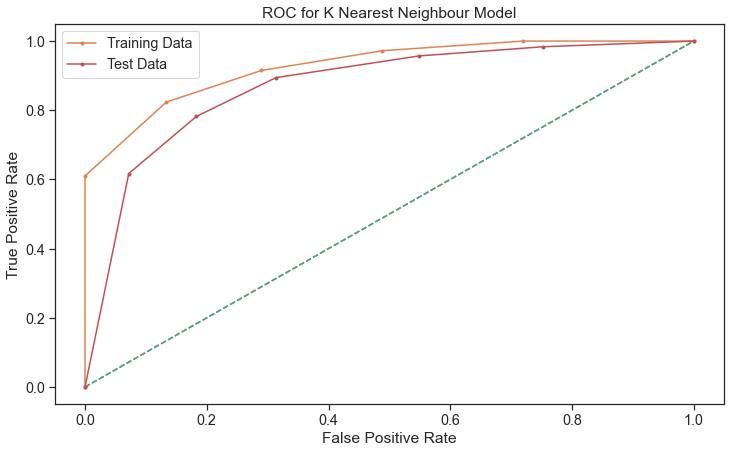

In [60]:
# AUC and ROC for the training data
plt.figure(figsize=(12,7))
# calculate AUC
auc = roc_auc_score(train_labels,KNN_model.predict_proba(x_train)[:,1])
print('AUC for the Training Data: %.3f' % auc)

#  calculate roc curve
fpr, tpr, thresholds = roc_curve(train_labels,KNN_model.predict_proba(x_train)[:,1])
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.',label = 'Training Data')

# AUC and ROC for the test data

# calculate AUC
auc = roc_auc_score(test_labels,KNN_model.predict_proba(x_test)[:,1])
print('AUC for the Test Data: %.3f' % auc)

#  calculate roc curve
fpr, tpr, thresholds = roc_curve(test_labels,KNN_model.predict_proba(x_test)[:,1])
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.',label='Test Data')
# show the plot
plt.legend(loc='best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for K Nearest Neighbour Model')
plt.show()

In [61]:
# empty list that will hold accuracy scores
ac_scores = []

# perform accuracy metrics for values from 1,3,5....19
for k in range(1,20,2):
    KNN = KNeighborsClassifier(n_neighbors=k)
    KNN.fit(x_train, train_labels)
    # evaluate test accuracy
    scores = KNN.score(x_test, test_labels)
    ac_scores.append(scores)

# changing to misclassification error
MCE = [1 - x for x in ac_scores]
MCE

[0.2171052631578947,
 0.1907894736842105,
 0.17543859649122806,
 0.18201754385964908,
 0.17763157894736847,
 0.17105263157894735,
 0.17763157894736847,
 0.17324561403508776,
 0.16666666666666663,
 0.16666666666666663]

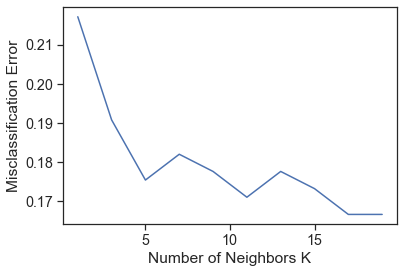

In [62]:
plt.plot(range(1,20,2), MCE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

In [63]:
0.927-0.870

0.05700000000000005

### As the difference between train and test accuracies is less than 10%, it is a valid model

# Naive Bayes Model

In [64]:
NB_model=GaussianNB()
NB_model.fit(x_train,train_labels)

GaussianNB()

In [65]:
NB_train_predict = NB_model.predict(x_train)
NB_test_predict = NB_model.predict(x_test)

In [66]:
NB_test_predict_prob=NB_model.predict_proba(x_test)
pd.DataFrame(NB_test_predict_prob).head()

,0,1
0,0.536792,0.463208
1,0.120285,0.879715
2,0.000332,0.999668
3,0.945240,0.054760
4,0.039267,0.960733


In [67]:
print('Training data score for Naive Bayes Model',format(NB_model.score(x_train, train_labels)))
print('Testing data score for Navie Bayes Model',format(NB_model.score(x_test, test_labels)))

Training data score for Naive Bayes Model 0.8350612629594723
Testing data score for Navie Bayes Model 0.8223684210526315


Accuracy for Naive Bayes Model is 

 0.8350612629594723


Classification report for Naive Bayes Model Training Data is 
               precision    recall  f1-score   support

           0       0.73      0.69      0.71       307
           1       0.88      0.90      0.89       754

    accuracy                           0.84      1061
   macro avg       0.80      0.79      0.80      1061
weighted avg       0.83      0.84      0.83      1061





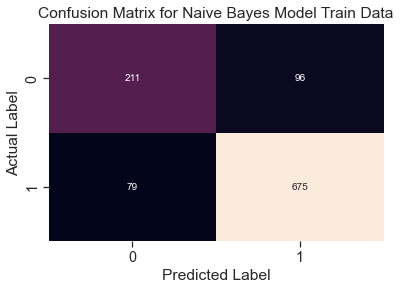

In [68]:
models_names={NB_model:'Naive Bayes Model'}

print('Accuracy for {} is'.format(models_names[NB_model]),'\n\n',accuracy_score(train_labels,NB_train_predict))
print('\n')
print('Classification report for {} Training Data is'.format(models_names[NB_model]),'\n',
      classification_report(train_labels,NB_train_predict))
print('\n')
sns.heatmap(confusion_matrix(train_labels,NB_train_predict),annot=True,fmt='d',cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title("Confusion Matrix for {} Train Data".format(models_names[NB_model]))
plt.show()

Accuracy for Naive Bayes Model is 

 0.8223684210526315


Classification report for Naive Bayes Model Testing Data is 
               precision    recall  f1-score   support

           0       0.74      0.73      0.73       153
           1       0.87      0.87      0.87       303

    accuracy                           0.82       456
   macro avg       0.80      0.80      0.80       456
weighted avg       0.82      0.82      0.82       456





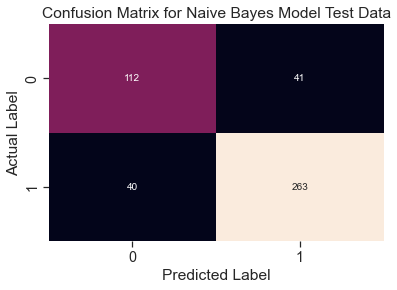

In [69]:
models_names={NB_model:'Naive Bayes Model'}

print('Accuracy for {} is'.format(models_names[NB_model]),'\n\n',accuracy_score(test_labels,NB_test_predict))
print('\n')
print('Classification report for {} Testing Data is'.format(models_names[NB_model]),'\n',
      classification_report(test_labels,NB_test_predict))
print('\n')
sns.heatmap(confusion_matrix(test_labels,NB_test_predict),annot=True,fmt='d',cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title("Confusion Matrix for {} Test Data".format(models_names[NB_model]))
plt.show()

AUC for the Training Data: 0.888
AUC for the Test Data: 0.876


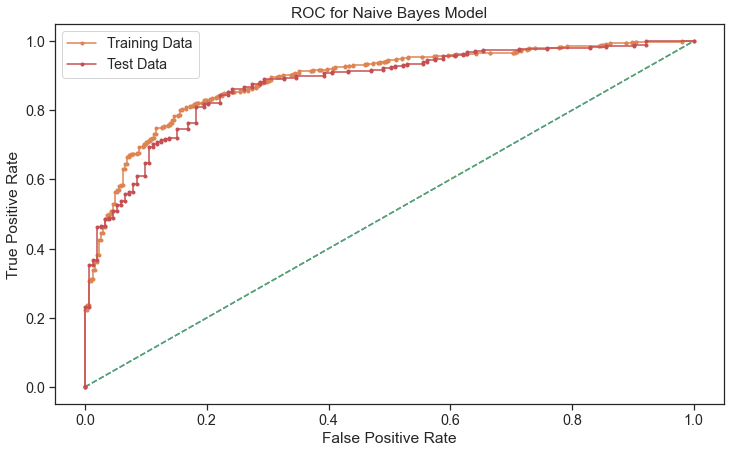

In [70]:
# AUC and ROC for the training data
plt.figure(figsize=(12,7))
# calculate AUC
auc = roc_auc_score(train_labels,NB_model.predict_proba(x_train)[:,1])
print('AUC for the Training Data: %.3f' % auc)

#  calculate roc curve
fpr, tpr, thresholds = roc_curve(train_labels,NB_model.predict_proba(x_train)[:,1])
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.',label = 'Training Data')

# AUC and ROC for the test data

# calculate AUC
auc = roc_auc_score(test_labels,NB_model.predict_proba(x_test)[:,1])
print('AUC for the Test Data: %.3f' % auc)

#  calculate roc curve
fpr, tpr, thresholds = roc_curve(test_labels,NB_model.predict_proba(x_test)[:,1])
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.',label='Test Data')
# show the plot
plt.legend(loc='best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Naive Bayes Model')
plt.show()

## ADA BOOST

In [71]:
ADB_model = AdaBoostClassifier(n_estimators=100,random_state=1)
ADB_model.fit(x_train,train_labels)

AdaBoostClassifier(n_estimators=100, random_state=1)

In [72]:
ADB_train_predict = ADB_model.predict(x_train)
ADB_test_predict = ADB_model.predict(x_test)

In [73]:
ADB_test_predict_prob=ADB_model.predict_proba(x_test)
pd.DataFrame(ADB_test_predict_prob).head()

,0,1
0,0.502173,0.497827
1,0.496755,0.503245
2,0.480057,0.519943
3,0.505525,0.494475
4,0.493868,0.506132


In [74]:
print('Training data score for ADA BOOST Model',format(ADB_model.score(x_train, train_labels)))
print('Testing data score for ADA BOOST Model',format(ADB_model.score(x_test, test_labels)))

Training data score for ADA BOOST Model 0.8501413760603205
Testing data score for ADA BOOST Model 0.8135964912280702


Accuracy for ADA BOOST Model is 

 0.8501413760603205


Classification report for ADA BOOST Model Training Data is 
               precision    recall  f1-score   support

           0       0.76      0.70      0.73       307
           1       0.88      0.91      0.90       754

    accuracy                           0.85      1061
   macro avg       0.82      0.80      0.81      1061
weighted avg       0.85      0.85      0.85      1061





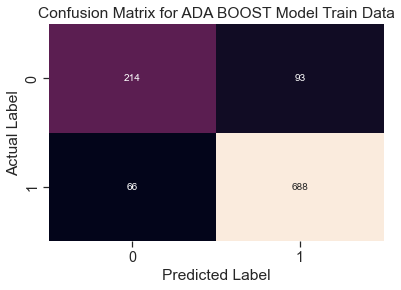

In [75]:
models_names={ADB_model:'ADA BOOST Model'}

print('Accuracy for {} is'.format(models_names[ADB_model]),'\n\n',accuracy_score(train_labels,ADB_train_predict))
print('\n')
print('Classification report for {} Training Data is'.format(models_names[ADB_model]),'\n',
      classification_report(train_labels,ADB_train_predict))
print('\n')
sns.heatmap(confusion_matrix(train_labels,ADB_train_predict),annot=True,fmt='d',cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title("Confusion Matrix for {} Train Data".format(models_names[ADB_model]))
plt.show()

Accuracy for ADA BOOST Model is 

 0.8135964912280702


Classification report for ADA BOOST Model Testing Data is 
               precision    recall  f1-score   support

           0       0.75      0.67      0.71       153
           1       0.84      0.88      0.86       303

    accuracy                           0.81       456
   macro avg       0.79      0.78      0.79       456
weighted avg       0.81      0.81      0.81       456





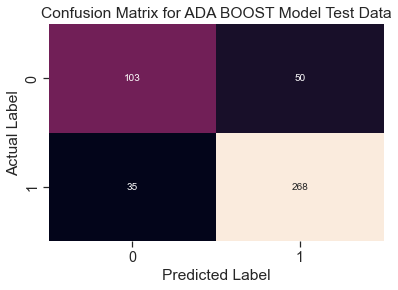

In [76]:
models_names={ADB_model:'ADA BOOST Model'}

print('Accuracy for {} is'.format(models_names[ADB_model]),'\n\n',accuracy_score(test_labels,ADB_test_predict))
print('\n')
print('Classification report for {} Testing Data is'.format(models_names[ADB_model]),'\n',
      classification_report(test_labels,ADB_test_predict))
print('\n')
sns.heatmap(confusion_matrix(test_labels,ADB_test_predict),annot=True,fmt='d',cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title("Confusion Matrix for {} Test Data".format(models_names[ADB_model]))
plt.show()

AUC for the Training Data: 0.915
AUC for the Test Data: 0.877


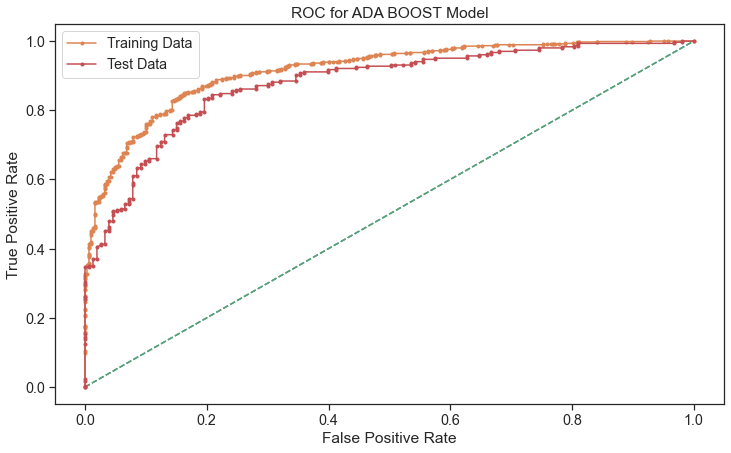

In [77]:
# AUC and ROC for the training data
plt.figure(figsize=(12,7))
# calculate AUC
auc = roc_auc_score(train_labels,ADB_model.predict_proba(x_train)[:,1])
print('AUC for the Training Data: %.3f' % auc)

#  calculate roc curve
fpr, tpr, thresholds = roc_curve(train_labels,ADB_model.predict_proba(x_train)[:,1])
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.',label = 'Training Data')

# AUC and ROC for the test data

# calculate AUC
auc = roc_auc_score(test_labels,ADB_model.predict_proba(x_test)[:,1])
print('AUC for the Test Data: %.3f' % auc)

#  calculate roc curve
fpr, tpr, thresholds = roc_curve(test_labels,ADB_model.predict_proba(x_test)[:,1])
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.',label='Test Data')
# show the plot
plt.legend(loc='best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for ADA BOOST Model')
plt.show()

## GRADIENT BOOSTING

In [78]:
gbcl_model = GradientBoostingClassifier(random_state=1)
gbcl_model.fit(x_train, train_labels)

GradientBoostingClassifier(random_state=1)

In [79]:
gbcl_train_predict = gbcl_model.predict(x_train)
gbcl_test_predict = gbcl_model.predict(x_test)

In [80]:
gbcl_test_predict_prob=gbcl_model.predict_proba(x_test)
pd.DataFrame(gbcl_test_predict_prob).head()

,0,1
0,0.690657,0.309343
1,0.236942,0.763058
2,0.001102,0.998898
3,0.840247,0.159753
4,0.111644,0.888356


In [81]:
print('Training data score for Gradient Boosting Model',format(gbcl_model.score(x_train, train_labels)))
print('Testing data score for Gradient Boosting Model',format(gbcl_model.score(x_test, test_labels)))

Training data score for Gradient Boosting Model 0.8925541941564562
Testing data score for Gradient Boosting Model 0.8355263157894737


Accuracy for Gradient Boosting Model is 

 0.8925541941564562


Classification report for Gradient Boosting Model Training Data is 
               precision    recall  f1-score   support

           0       0.84      0.78      0.81       307
           1       0.91      0.94      0.93       754

    accuracy                           0.89      1061
   macro avg       0.88      0.86      0.87      1061
weighted avg       0.89      0.89      0.89      1061





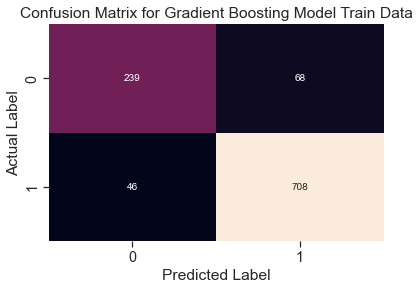

In [82]:
models_names={gbcl_model:'Gradient Boosting Model'}
print('Accuracy for {} is'.format(models_names[gbcl_model]),'\n\n',accuracy_score(train_labels,gbcl_train_predict))
print('\n')
print('Classification report for {} Training Data is'.format(models_names[gbcl_model]),'\n',
      classification_report(train_labels,gbcl_train_predict))
print('\n')
sns.heatmap(confusion_matrix(train_labels,gbcl_train_predict),annot=True,fmt='d',cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title("Confusion Matrix for {} Train Data".format(models_names[gbcl_model]))
plt.show()

Accuracy for Gradient Boosting Model is 

 0.8355263157894737


Classification report for Gradient Boosting Model Testing Data is 
               precision    recall  f1-score   support

           0       0.80      0.69      0.74       153
           1       0.85      0.91      0.88       303

    accuracy                           0.84       456
   macro avg       0.82      0.80      0.81       456
weighted avg       0.83      0.84      0.83       456





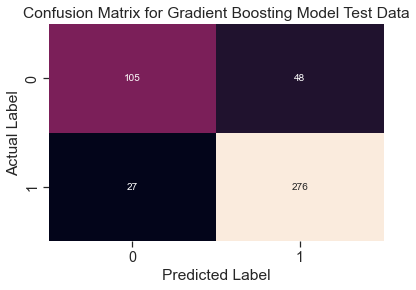

In [83]:
models_names={gbcl_model:'Gradient Boosting Model'}

print('Accuracy for {} is'.format(models_names[gbcl_model]),'\n\n',accuracy_score(test_labels,gbcl_test_predict))
print('\n')
print('Classification report for {} Testing Data is'.format(models_names[gbcl_model]),'\n',
      classification_report(test_labels,gbcl_test_predict))
print('\n')
sns.heatmap(confusion_matrix(test_labels,gbcl_test_predict),annot=True,fmt='d',cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title("Confusion Matrix for {} Test Data".format(models_names[gbcl_model]))
plt.show()

AUC for the Training Data: 0.951
AUC for the Test Data: 0.899


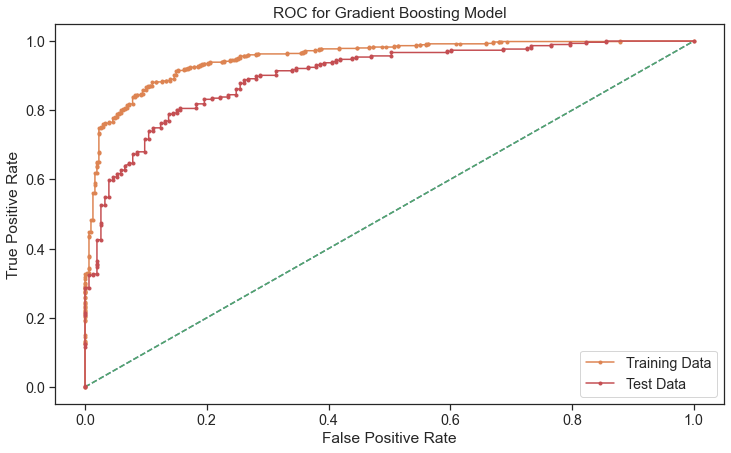

In [84]:
# AUC and ROC for the training data
plt.figure(figsize=(12,7))
# calculate AUC
auc = roc_auc_score(train_labels,gbcl_model.predict_proba(x_train)[:,1])
print('AUC for the Training Data: %.3f' % auc)

#  calculate roc curve
fpr, tpr, thresholds = roc_curve(train_labels,gbcl_model.predict_proba(x_train)[:,1])
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.',label = 'Training Data')

# AUC and ROC for the test data

# calculate AUC
auc = roc_auc_score(test_labels,gbcl_model.predict_proba(x_test)[:,1])
print('AUC for the Test Data: %.3f' % auc)

#  calculate roc curve
fpr, tpr, thresholds = roc_curve(test_labels,gbcl_model.predict_proba(x_test)[:,1])
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.',label='Test Data')
# show the plot
plt.legend(loc='best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Gradient Boosting Model')
plt.show()


## Extreme Gradient Boosting

In [85]:
xgb_model = XGBClassifier()
xgb_model.fit(x_train, train_labels)

[15:42:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [86]:
xgb_train_predict = xgb_model.predict(x_train)
xgb_test_predict = xgb_model.predict(x_test)

In [87]:
xgb_test_predict_prob=xgb_model.predict_proba(x_test)
pd.DataFrame(xgb_test_predict_prob).head()

,0,1
0,0.905146,0.094854
1,0.573790,0.426210
2,0.000070,0.999930
3,0.901116,0.098884
4,0.004664,0.995336


In [88]:
print('Training data score for Extreme Gradient Boosting Model',format(xgb_model.score(x_train, train_labels)))
print('Testing data score for Extreme Gradient Boosting Model',format(xgb_model.score(x_test, test_labels)))

Training data score for Extreme Gradient Boosting Model 0.998114985862394
Testing data score for Extreme Gradient Boosting Model 0.8245614035087719


Accuracy for Extreme Gradient Boosting Model is 

 0.998114985862394


Classification report for Extreme Gradient Boosting Model Training Data is 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       307
           1       1.00      1.00      1.00       754

    accuracy                           1.00      1061
   macro avg       1.00      1.00      1.00      1061
weighted avg       1.00      1.00      1.00      1061





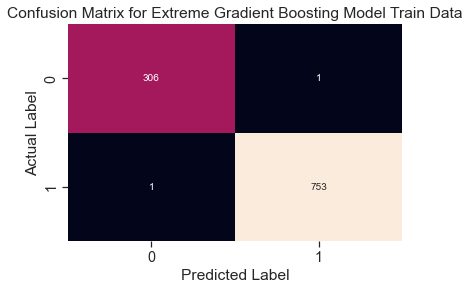

In [89]:
models_names={xgb_model:'Extreme Gradient Boosting Model'}
print('Accuracy for {} is'.format(models_names[xgb_model]),'\n\n',accuracy_score(train_labels,xgb_train_predict))
print('\n')
print('Classification report for {} Training Data is'.format(models_names[xgb_model]),'\n',
      classification_report(train_labels,xgb_train_predict))
print('\n')
sns.heatmap(confusion_matrix(train_labels,xgb_train_predict),annot=True,fmt='d',cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title("Confusion Matrix for {} Train Data".format(models_names[xgb_model]))
plt.show()

Accuracy for Extreme Gradient Boosting Model is 

 0.8245614035087719


Classification report for Extreme Gradient Boosting Model Testing Data is 
               precision    recall  f1-score   support

           0       0.74      0.73      0.74       153
           1       0.87      0.87      0.87       303

    accuracy                           0.82       456
   macro avg       0.80      0.80      0.80       456
weighted avg       0.82      0.82      0.82       456





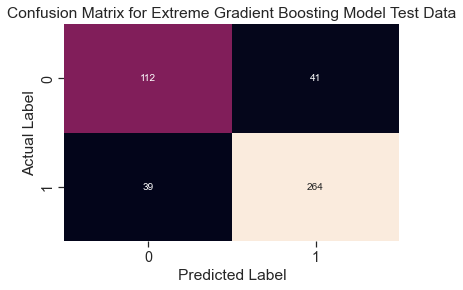

In [90]:
models_names={xgb_model:'Extreme Gradient Boosting Model'}
print('Accuracy for {} is'.format(models_names[xgb_model]),'\n\n',accuracy_score(test_labels,xgb_test_predict))
print('\n')
print('Classification report for {} Testing Data is'.format(models_names[xgb_model]),'\n',
      classification_report(test_labels,xgb_test_predict))
print('\n')
sns.heatmap(confusion_matrix(test_labels,xgb_test_predict),annot=True,fmt='d',cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title("Confusion Matrix for {} Test Data".format(models_names[xgb_model]))
plt.show()

AUC for the Training Data: 1.000
AUC for the Test Data: 0.886


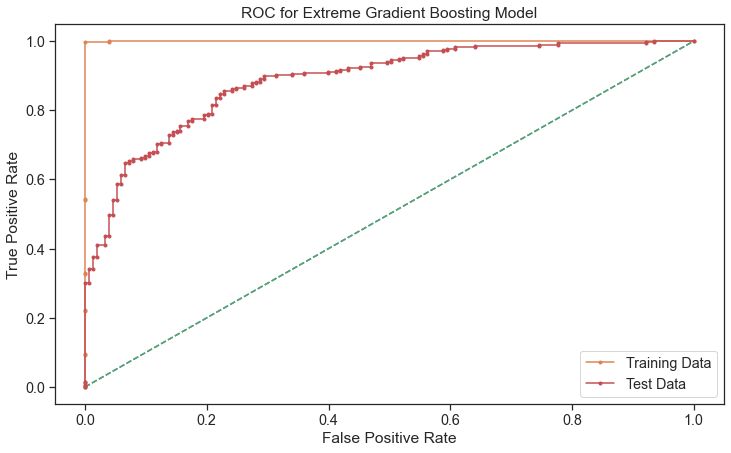

In [91]:
# AUC and ROC for the training data
plt.figure(figsize=(12,7))
# calculate AUC
auc = roc_auc_score(train_labels,xgb_model.predict_proba(x_train)[:,1])
print('AUC for the Training Data: %.3f' % auc)

#  calculate roc curve
fpr, tpr, thresholds = roc_curve(train_labels,xgb_model.predict_proba(x_train)[:,1])
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.',label = 'Training Data')

# AUC and ROC for the test data

# calculate AUC
auc = roc_auc_score(test_labels,xgb_model.predict_proba(x_test)[:,1])
print('AUC for the Test Data: %.3f' % auc)

#  calculate roc curve
fpr, tpr, thresholds = roc_curve(test_labels,xgb_model.predict_proba(x_test)[:,1])
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.',label='Test Data')
# show the plot
plt.legend(loc='best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Extreme Gradient Boosting Model')
plt.show()


## Random Forest Model

In [92]:
RF_model=RandomForestClassifier(n_estimators=100,random_state=1)
RF_model.fit(x_train, train_labels)

RandomForestClassifier(random_state=1)

In [93]:
RF_train_predict = RF_model.predict(x_train)
RF_test_predict = RF_model.predict(x_test)

In [94]:
RF_test_predict_prob=RF_model.predict_proba(x_test)
pd.DataFrame(RF_test_predict_prob).head()

,0,1
0,0.66,0.34
1,0.32,0.68
2,0.04,0.96
3,0.78,0.22
4,0.07,0.93


In [95]:
print('Training data score for Random Forest Model',format(RF_model.score(x_train, train_labels)))
print('Testing data score for Random Forest Model',format(RF_model.score(x_test, test_labels)))

Training data score for Random Forest Model 1.0
Testing data score for Random Forest Model 0.831140350877193


Accuracy for Random Forest Model is 

 1.0


Classification report for Random Forest Model Training Data is 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       307
           1       1.00      1.00      1.00       754

    accuracy                           1.00      1061
   macro avg       1.00      1.00      1.00      1061
weighted avg       1.00      1.00      1.00      1061





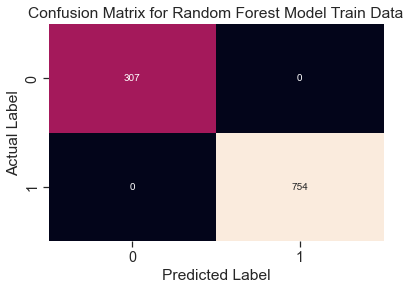

In [96]:
models_names={RF_model:'Random Forest Model'}
print('Accuracy for {} is'.format(models_names[RF_model]),'\n\n',accuracy_score(train_labels,RF_train_predict))
print('\n')
print('Classification report for {} Training Data is'.format(models_names[RF_model]),'\n',
      classification_report(train_labels,RF_train_predict))
print('\n')
sns.heatmap(confusion_matrix(train_labels,RF_train_predict),annot=True,fmt='d',cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title("Confusion Matrix for {} Train Data".format(models_names[RF_model]))
plt.show()

Accuracy for Random Forest Model is 

 0.831140350877193


Classification report for Random Forest Model Testing Data is 
               precision    recall  f1-score   support

           0       0.79      0.68      0.73       153
           1       0.85      0.91      0.88       303

    accuracy                           0.83       456
   macro avg       0.82      0.79      0.80       456
weighted avg       0.83      0.83      0.83       456





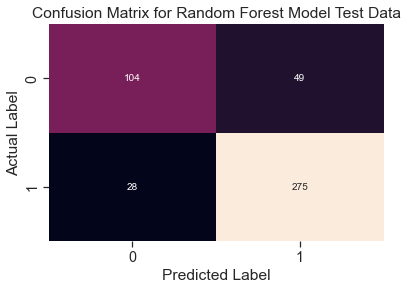

In [97]:
models_names={RF_model:'Random Forest Model'}

print('Accuracy for {} is'.format(models_names[RF_model]),'\n\n',accuracy_score(test_labels,RF_test_predict))
print('\n')
print('Classification report for {} Testing Data is'.format(models_names[RF_model]),'\n',
      classification_report(test_labels,RF_test_predict))
print('\n')
sns.heatmap(confusion_matrix(test_labels,RF_test_predict),annot=True,fmt='d',cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title("Confusion Matrix for {} Test Data".format(models_names[RF_model]))
plt.show()


AUC for the Training Data: 1.000
AUC for the Test Data: 0.896


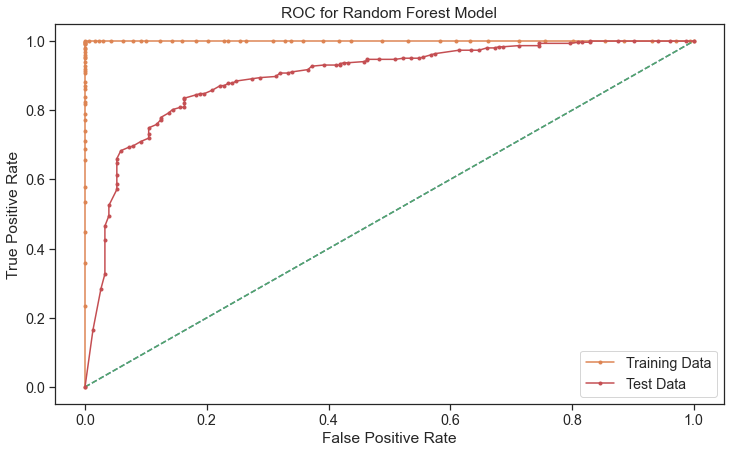

In [98]:
# AUC and ROC for the training data
plt.figure(figsize=(12,7))
# calculate AUC
auc = roc_auc_score(train_labels,RF_model.predict_proba(x_train)[:,1])
print('AUC for the Training Data: %.3f' % auc)

#  calculate roc curve
fpr, tpr, thresholds = roc_curve(train_labels,RF_model.predict_proba(x_train)[:,1])
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.',label = 'Training Data')

# AUC and ROC for the test data

# calculate AUC
auc = roc_auc_score(test_labels,RF_model.predict_proba(x_test)[:,1])
print('AUC for the Test Data: %.3f' % auc)

#  calculate roc curve
fpr, tpr, thresholds = roc_curve(test_labels,RF_model.predict_proba(x_test)[:,1])
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.',label='Test Data')
# show the plot
plt.legend(loc='best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Random Forest Model')
plt.show()

# MODEL TUNING- Grid Serach

### Logistic Regression-GridSearch

In [99]:
grid={'penalty':['l1','l2','none'],
     'solver':['sag','liblinear','saga','ibfgs','newton-cg'],
      'max_iter':[1000,10000,100000],
     'tol':[0.0001,0.01,0.000001]}

In [100]:
grid_search=GridSearchCV(estimator=lm,param_grid=grid,cv=5,n_jobs=2)

In [101]:
lmgs=grid_search.fit(x_train,train_labels)

convergence after 19 epochs took 0 seconds


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    0.0s finished


In [102]:
print(lmgs.best_params_)
print('\n')
print(lmgs.best_estimator_)

{'max_iter': 1000, 'penalty': 'l1', 'solver': 'saga', 'tol': 0.0001}


LogisticRegression(max_iter=1000, n_jobs=2, penalty='l1', random_state=123,
                   solver='saga', verbose=True)


In [103]:
lm_best_model=lmgs.best_estimator_

In [104]:
lmgstrain_predict_grid=lm_best_model.predict(x_train)
lmgstest_predict_grid=lm_best_model.predict(x_test)

In [105]:
lmgstest_predict_prob_grid=lm_best_model.predict_proba(x_test)
pd.DataFrame(lmgstest_predict_prob_grid).head()

,0,1
0,0.419671,0.580329
1,0.149946,0.850054
2,0.007635,0.992365
3,0.831360,0.168640
4,0.072350,0.927650


Accuracy for Logistics Regression after Grid Search is 

 0.8322337417530632


Classification report for Logistics Regression after Grid Search Training Data is 
               precision    recall  f1-score   support

           0       0.75      0.64      0.69       307
           1       0.86      0.91      0.89       754

    accuracy                           0.83      1061
   macro avg       0.80      0.77      0.79      1061
weighted avg       0.83      0.83      0.83      1061





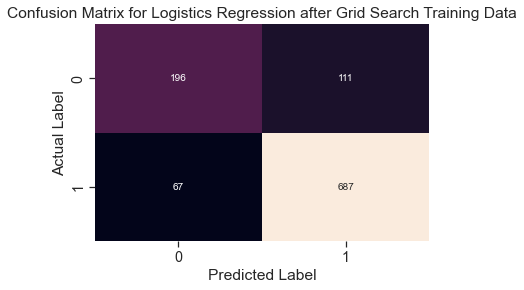

In [106]:
## Confusion matrix on the training data based on best estimator
models_names={lmgs:'Logistics Regression after Grid Search'}

print('Accuracy for {} is'.format(models_names[lmgs]),'\n\n',accuracy_score(train_labels,lmgstrain_predict_grid))
print('\n')
print('Classification report for {} Training Data is'.format(models_names[lmgs]),'\n',
      classification_report(train_labels,lmgstrain_predict_grid))
print('\n')
sns.heatmap(confusion_matrix(train_labels,lmgstrain_predict_grid),annot=True,fmt='d',cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title("Confusion Matrix for {} Training Data".format(models_names[lmgs]))
plt.show()

Accuracy for Logistics Regression after Grid Search is 

 0.8333333333333334


Classification report for Logistics Regression after Grid Search Testing Data is 
               precision    recall  f1-score   support

           0       0.76      0.73      0.75       153
           1       0.87      0.88      0.88       303

    accuracy                           0.83       456
   macro avg       0.81      0.81      0.81       456
weighted avg       0.83      0.83      0.83       456





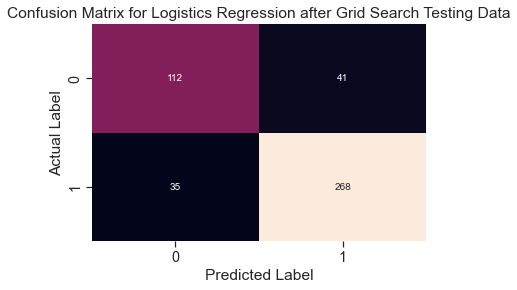

In [107]:
## Confusion matrix on the testing data based on best estimator
models_names={lmgs:'Logistics Regression after Grid Search'}

print('Accuracy for {} is'.format(models_names[lmgs]),'\n\n',accuracy_score(test_labels,lmgstest_predict_grid))
print('\n')
print('Classification report for {} Testing Data is'.format(models_names[lmgs]),'\n',
      classification_report(test_labels,lmgstest_predict_grid))
print('\n')
sns.heatmap(confusion_matrix(test_labels,lmgstest_predict_grid),annot=True,fmt='d',cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title("Confusion Matrix for {} Testing Data".format(models_names[lmgs]))
plt.show()

AUC for the Training Data: 0.890
AUC for the Test Data: 0.883


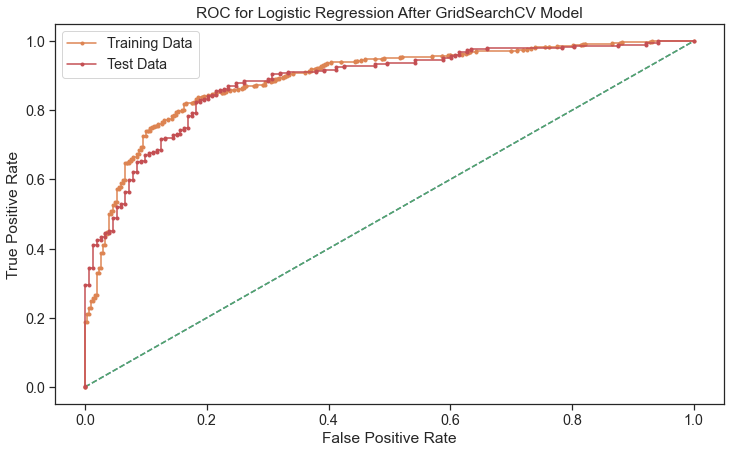

In [108]:
# AUC and ROC for the training data
plt.figure(figsize=(12,7))
# calculate AUC
auc = roc_auc_score(train_labels,lm_best_model.predict_proba(x_train)[:,1])
print('AUC for the Training Data: %.3f' % auc)

#  calculate roc curve
fpr, tpr, thresholds = roc_curve(train_labels,lm_best_model.predict_proba(x_train)[:,1])
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.',label = 'Training Data')

# AUC and ROC for the test data

# calculate AUC
auc = roc_auc_score(test_labels,lm_best_model.predict_proba(x_test)[:,1])
print('AUC for the Test Data: %.3f' % auc)

#  calculate roc curve
fpr, tpr, thresholds = roc_curve(test_labels,lm_best_model.predict_proba(x_test)[:,1])
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.',label='Test Data')
# show the plot
plt.legend(loc='best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Logistic Regression After GridSearchCV Model')
plt.show()


### Linear Discriminant Analysis-GridSearch

In [109]:
estimator_lda=LinearDiscriminantAnalysis(shrinkage='auto')
parameters_lda={'solver':('svd','lsqr','eigen'),'n_components':(1,5,1)}

In [110]:
clf=GridSearchCV(estimator=estimator_lda,param_grid=parameters_lda,n_jobs=2,cv=5)

In [111]:
ldags_model=clf.fit(x_train,train_labels)

In [112]:
print(ldags_model.best_params_)
print('\n')
print(ldags_model.best_estimator_)

{'n_components': 1, 'solver': 'lsqr'}


LinearDiscriminantAnalysis(n_components=1, shrinkage='auto', solver='lsqr')


In [113]:
lda_best_model=ldags_model.best_estimator_

In [114]:
ldagstrain_predict_grid=lda_best_model.predict(x_train)
ldagstest_predict_grid=lda_best_model.predict(x_test)

In [115]:
ldagstest_predict_prob_grid=lda_best_model.predict_proba(x_test)
pd.DataFrame(ldagstest_predict_prob_grid).head()

,0,1
0,0.464078,0.535922
1,0.138634,0.861366
2,0.004855,0.995145
3,0.870216,0.129784
4,0.054100,0.945900


Accuracy for Linear Discriminant Analysis after Grid Search is 

 0.8331762488218661


Classification report for Linear Discriminant Analysis after Grid Search Training Data is 
               precision    recall  f1-score   support

           0       0.74      0.65      0.69       307
           1       0.86      0.91      0.89       754

    accuracy                           0.83      1061
   macro avg       0.80      0.78      0.79      1061
weighted avg       0.83      0.83      0.83      1061





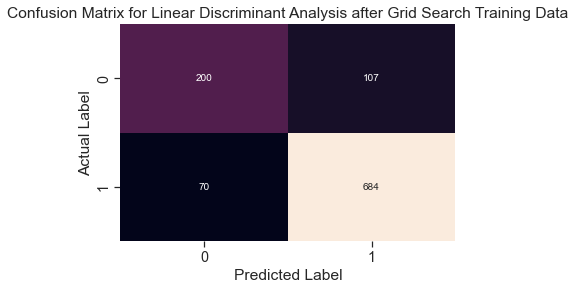

In [116]:
## Confusion matrix on the training data based on best estimator
models_names={ldags_model:'Linear Discriminant Analysis after Grid Search'}

print('Accuracy for {} is'.format(models_names[ldags_model]),'\n\n',accuracy_score(train_labels,ldagstrain_predict_grid))
print('\n')
print('Classification report for {} Training Data is'.format(models_names[ldags_model]),'\n',
      classification_report(train_labels,ldagstrain_predict_grid))
print('\n')
sns.heatmap(confusion_matrix(train_labels,ldagstrain_predict_grid),annot=True,fmt='d',cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title("Confusion Matrix for {} Training Data".format(models_names[ldags_model]))
plt.show()

Accuracy for Linear Discriminant Analysis after Grid Search is 

 0.8355263157894737


Classification report for Linear Discriminant Analysis after Grid Search Testing Data is 
               precision    recall  f1-score   support

           0       0.76      0.74      0.75       153
           1       0.87      0.88      0.88       303

    accuracy                           0.84       456
   macro avg       0.82      0.81      0.81       456
weighted avg       0.83      0.84      0.83       456





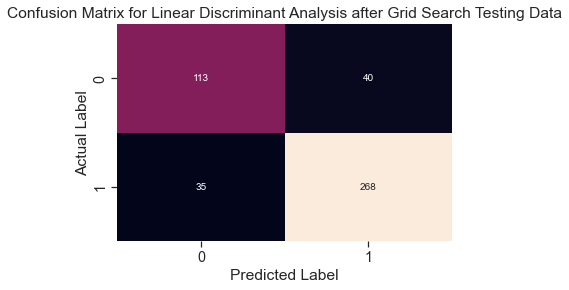

In [117]:
## Confusion matrix on the testing data based on best estimator
models_names={ldags_model:'Linear Discriminant Analysis after Grid Search'}

print('Accuracy for {} is'.format(models_names[ldags_model]),'\n\n',accuracy_score(test_labels,ldagstest_predict_grid))
print('\n')
print('Classification report for {} Testing Data is'.format(models_names[ldags_model]),'\n',
      classification_report(test_labels,ldagstest_predict_grid))
print('\n')
sns.heatmap(confusion_matrix(test_labels,ldagstest_predict_grid),annot=True,fmt='d',cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title("Confusion Matrix for {} Testing Data".format(models_names[ldags_model]))
plt.show()

AUC for the Training Data: 0.890
AUC for the Test Data: 0.887


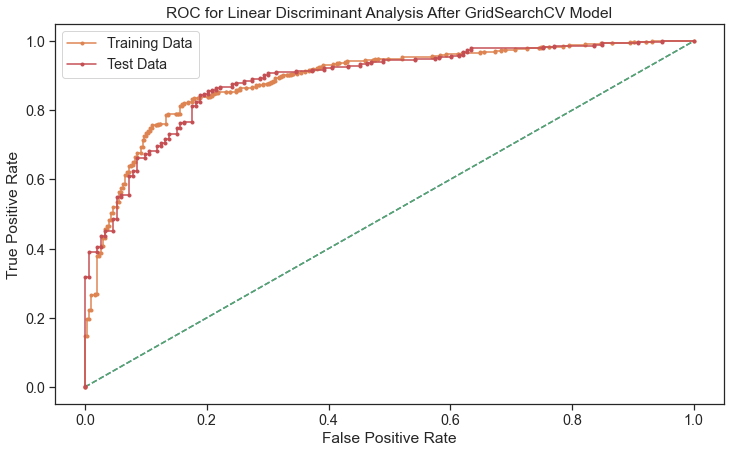

In [118]:
# AUC and ROC for the training data
plt.figure(figsize=(12,7))
# calculate AUC
auc = roc_auc_score(train_labels,lda_best_model.predict_proba(x_train)[:,1])
print('AUC for the Training Data: %.3f' % auc)

#  calculate roc curve
fpr, tpr, thresholds = roc_curve(train_labels,lda_best_model.predict_proba(x_train)[:,1])
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.',label = 'Training Data')

# AUC and ROC for the test data

# calculate AUC
auc = roc_auc_score(test_labels,lda_best_model.predict_proba(x_test)[:,1])
print('AUC for the Test Data: %.3f' % auc)

#  calculate roc curve
fpr, tpr, thresholds = roc_curve(test_labels,lda_best_model.predict_proba(x_test)[:,1])
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.',label='Test Data')
# show the plot
plt.legend(loc='best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Linear Discriminant Analysis After GridSearchCV Model')
plt.show()

## K-Nearest Neighbor-GridSearch

In [119]:
k_range = list(range(1, 31,2))
param_grid = dict(n_neighbors=k_range)

In [120]:
grid = GridSearchCV(KNN_model, param_grid, cv=10, return_train_score=False,verbose=1)

In [121]:
knngs=grid.fit(x_train,train_labels)

Fitting 10 folds for each of 15 candidates, totalling 150 fits


In [122]:
print(knngs.best_params_)
print('\n')
print(knngs.best_estimator_)

{'n_neighbors': 25}


KNeighborsClassifier(n_neighbors=25)


In [123]:
knn_best_model=knngs.best_estimator_

In [124]:
knngstrain_predict_grid=knn_best_model.predict(x_train)
knngstest_predict_grid=knn_best_model.predict(x_test)

In [125]:
knngstest_predict_prob_grid=knn_best_model.predict_proba(x_test)
pd.DataFrame(knngstest_predict_prob_grid).head()

,0,1
0,0.56,0.44
1,0.08,0.92
2,0.00,1.00
3,0.84,0.16
4,0.12,0.88


Accuracy for K-Nearest Neighbor after Grid Search is 

 0.8378887841658812


Classification report for K-Nearest Neighbor after Grid Search Training Data is 
               precision    recall  f1-score   support

           0       0.76      0.64      0.70       307
           1       0.86      0.92      0.89       754

    accuracy                           0.84      1061
   macro avg       0.81      0.78      0.79      1061
weighted avg       0.83      0.84      0.83      1061





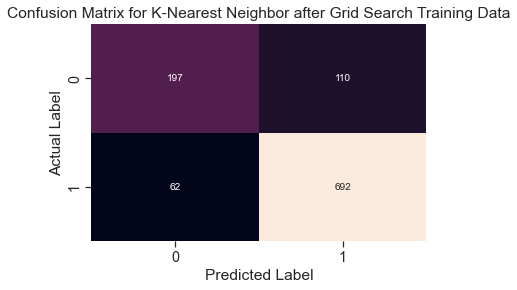

In [126]:
## Confusion matrix on the training data based on best estimator
models_names={knngs:'K-Nearest Neighbor after Grid Search'}

print('Accuracy for {} is'.format(models_names[knngs]),'\n\n',accuracy_score(train_labels,knngstrain_predict_grid))
print('\n')
print('Classification report for {} Training Data is'.format(models_names[knngs]),'\n',
      classification_report(train_labels,knngstrain_predict_grid))
print('\n')
sns.heatmap(confusion_matrix(train_labels,knngstrain_predict_grid),annot=True,fmt='d',cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title("Confusion Matrix for {} Training Data".format(models_names[knngs]))
plt.show()

Accuracy for K-Nearest Neighbor after Grid Search is 

 0.831140350877193


Classification report for K-Nearest Neighbor after Grid Search Testing Data is 
               precision    recall  f1-score   support

           0       0.80      0.67      0.73       153
           1       0.84      0.91      0.88       303

    accuracy                           0.83       456
   macro avg       0.82      0.79      0.80       456
weighted avg       0.83      0.83      0.83       456





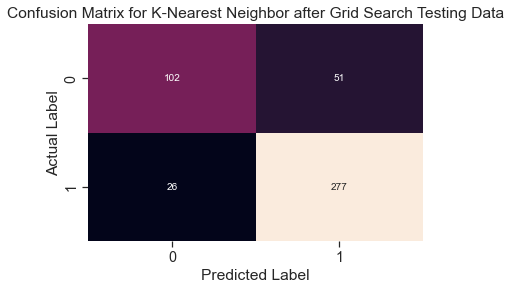

In [127]:
## Confusion matrix on the testing data based on best estimator
models_names={knngs:'K-Nearest Neighbor after Grid Search'}

print('Accuracy for {} is'.format(models_names[knngs]),'\n\n',accuracy_score(test_labels,knngstest_predict_grid))
print('\n')
print('Classification report for {} Testing Data is'.format(models_names[knngs]),'\n',
      classification_report(test_labels,knngstest_predict_grid))
print('\n')
sns.heatmap(confusion_matrix(test_labels,knngstest_predict_grid),annot=True,fmt='d',cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title("Confusion Matrix for {} Testing Data".format(models_names[knngs]))
plt.show()

AUC for the Training Data: 0.902
AUC for the Test Data: 0.887


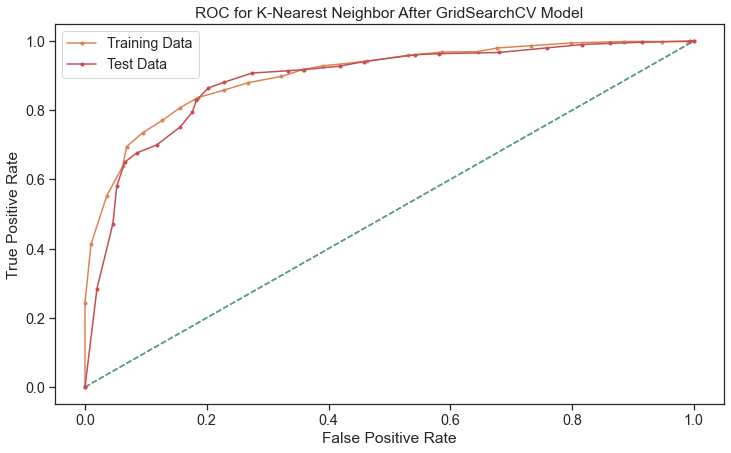

In [128]:
# AUC and ROC for the training data
plt.figure(figsize=(12,7))
# calculate AUC
auc = roc_auc_score(train_labels,knn_best_model.predict_proba(x_train)[:,1])
print('AUC for the Training Data: %.3f' % auc)

#  calculate roc curve
fpr, tpr, thresholds = roc_curve(train_labels,knn_best_model.predict_proba(x_train)[:,1])
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.',label = 'Training Data')

# AUC and ROC for the test data

# calculate AUC
auc = roc_auc_score(test_labels,knn_best_model.predict_proba(x_test)[:,1])
print('AUC for the Test Data: %.3f' % auc)

#  calculate roc curve
fpr, tpr, thresholds = roc_curve(test_labels,knn_best_model.predict_proba(x_test)[:,1])
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.',label='Test Data')
# show the plot
plt.legend(loc='best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for K-Nearest Neighbor After GridSearchCV Model')
plt.show()

## Naive Bayes-GridSearch

In [129]:
params = {'var_smoothing': [1e-8,1e-7,1e-6,1e-5,1e-4]}
nb_grid = GridSearchCV(NB_model, param_grid=params, n_jobs=-1, cv=5, verbose=5)

In [130]:
nbgs=nb_grid.fit(x_train,train_labels)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [131]:
print(nbgs.best_params_)
print('\n')
print(nbgs.best_estimator_)

{'var_smoothing': 1e-08}


GaussianNB(var_smoothing=1e-08)


In [132]:
nb_best_model=nbgs.best_estimator_

In [133]:
nbgstrain_predict_grid=nb_best_model.predict(x_train)
nbgstest_predict_grid=nb_best_model.predict(x_test)

In [134]:
nbgstest_predict_prob_grid=nb_best_model.predict_proba(x_test)
pd.DataFrame(nbgstest_predict_prob_grid).head()

,0,1
0,0.536792,0.463208
1,0.120285,0.879715
2,0.000332,0.999668
3,0.945240,0.054760
4,0.039267,0.960733


Accuracy for Naive Bayes after Grid Search is 

 0.8350612629594723


Classification report for Naive Bayes after Grid Search Training Data is 
               precision    recall  f1-score   support

           0       0.73      0.69      0.71       307
           1       0.88      0.90      0.89       754

    accuracy                           0.84      1061
   macro avg       0.80      0.79      0.80      1061
weighted avg       0.83      0.84      0.83      1061





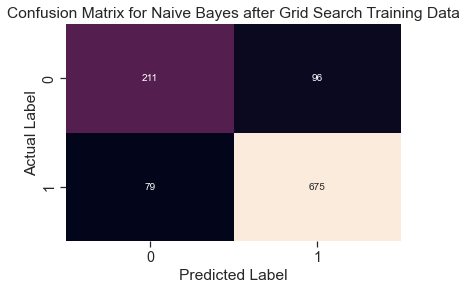

In [135]:
## Confusion matrix on the training data based on best estimator
models_names={nbgs:'Naive Bayes after Grid Search'}

print('Accuracy for {} is'.format(models_names[nbgs]),'\n\n',accuracy_score(train_labels,nbgstrain_predict_grid))
print('\n')
print('Classification report for {} Training Data is'.format(models_names[nbgs]),'\n',
      classification_report(train_labels,nbgstrain_predict_grid))
print('\n')
sns.heatmap(confusion_matrix(train_labels,nbgstrain_predict_grid),annot=True,fmt='d',cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title("Confusion Matrix for {} Training Data".format(models_names[nbgs]))
plt.show()

Accuracy for Naive Bayes after Grid Search is 

 0.8223684210526315


Classification report for Naive Bayes after Grid Search Testing Data is 
               precision    recall  f1-score   support

           0       0.74      0.73      0.73       153
           1       0.87      0.87      0.87       303

    accuracy                           0.82       456
   macro avg       0.80      0.80      0.80       456
weighted avg       0.82      0.82      0.82       456





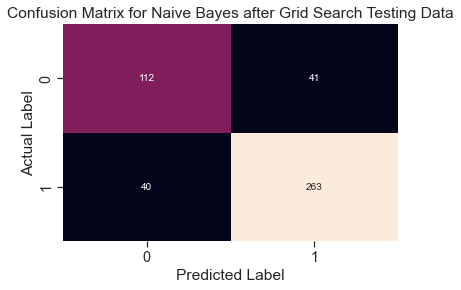

In [136]:
## Confusion matrix on the testing data based on best estimator
models_names={nbgs:'Naive Bayes after Grid Search'}

print('Accuracy for {} is'.format(models_names[nbgs]),'\n\n',accuracy_score(test_labels,nbgstest_predict_grid))
print('\n')
print('Classification report for {} Testing Data is'.format(models_names[nbgs]),'\n',
      classification_report(test_labels,nbgstest_predict_grid))
print('\n')
sns.heatmap(confusion_matrix(test_labels,nbgstest_predict_grid),annot=True,fmt='d',cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title("Confusion Matrix for {} Testing Data".format(models_names[nbgs]))
plt.show()

AUC for the Training Data: 0.888
AUC for the Test Data: 0.876


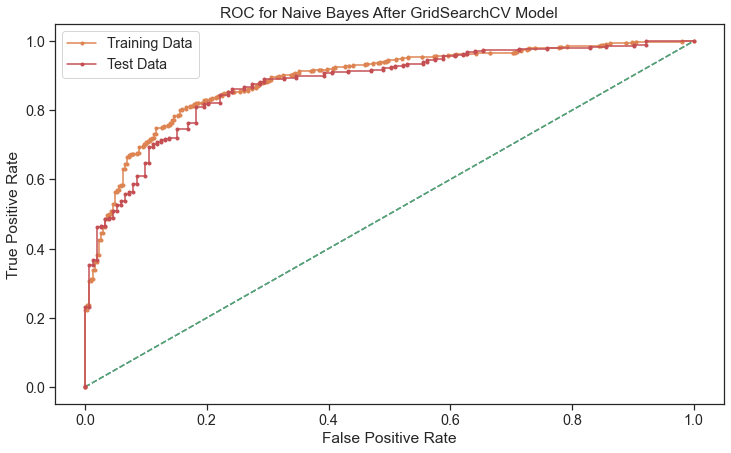

In [137]:
# AUC and ROC for the training data
plt.figure(figsize=(12,7))
# calculate AUC
auc = roc_auc_score(train_labels,nb_best_model.predict_proba(x_train)[:,1])
print('AUC for the Training Data: %.3f' % auc)

#  calculate roc curve
fpr, tpr, thresholds = roc_curve(train_labels,nb_best_model.predict_proba(x_train)[:,1])
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.',label = 'Training Data')

# AUC and ROC for the test data

# calculate AUC
auc = roc_auc_score(test_labels,nb_best_model.predict_proba(x_test)[:,1])
print('AUC for the Test Data: %.3f' % auc)

#  calculate roc curve
fpr, tpr, thresholds = roc_curve(test_labels,nb_best_model.predict_proba(x_test)[:,1])
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.',label='Test Data')
# show the plot
plt.legend(loc='best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Naive Bayes After GridSearchCV Model')
plt.show()

## ADA BOOST-GridSearch

In [138]:
searchgrid={'algorithm':['SAMME', 'SAMME.R'],'n_estimators':[500,1000,1500],'learning_rate':[0.0001,0.001,0.1,10]}
adb_grid = GridSearchCV(estimator=ADB_model, param_grid=searchgrid, n_jobs=2, cv=3, verbose=3)

In [139]:
adbgs=adb_grid.fit(x_train,train_labels)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


In [140]:
print(adbgs.best_params_)
print('\n')
print(adbgs.best_estimator_)

{'algorithm': 'SAMME', 'learning_rate': 0.1, 'n_estimators': 500}


AdaBoostClassifier(algorithm='SAMME', learning_rate=0.1, n_estimators=500,
                   random_state=1)


In [141]:
adb_best_model=adbgs.best_estimator_

In [142]:
adbgstrain_predict_grid=adb_best_model.predict(x_train)
adbgstest_predict_grid=adb_best_model.predict(x_test)

In [143]:
adbgstest_predict_prob_grid=adb_best_model.predict_proba(x_test)
pd.DataFrame(adbgstest_predict_prob_grid).head()

,0,1
0,0.498565,0.501435
1,0.445879,0.554121
2,0.315547,0.684453
3,0.554511,0.445489
4,0.458019,0.541981


Accuracy for ADA Boost after Grid Search is 

 0.8369462770970783


Classification report for ADA Boost after Grid Search Training Data is 
               precision    recall  f1-score   support

           0       0.78      0.61      0.68       307
           1       0.85      0.93      0.89       754

    accuracy                           0.84      1061
   macro avg       0.82      0.77      0.79      1061
weighted avg       0.83      0.84      0.83      1061





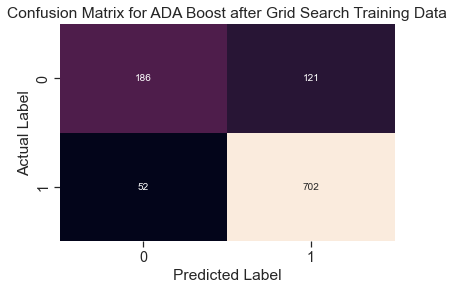

In [144]:
## Confusion matrix on the training data based on best estimator
models_names={adbgs:'ADA Boost after Grid Search'}

print('Accuracy for {} is'.format(models_names[adbgs]),'\n\n',accuracy_score(train_labels,adbgstrain_predict_grid))
print('\n')
print('Classification report for {} Training Data is'.format(models_names[adbgs]),'\n',
      classification_report(train_labels,adbgstrain_predict_grid))
print('\n')
sns.heatmap(confusion_matrix(train_labels,adbgstrain_predict_grid),annot=True,fmt='d',cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title("Confusion Matrix for {} Training Data".format(models_names[adbgs]))
plt.show()

Accuracy for ADA Boost after Grid Search is 

 0.8092105263157895


Classification report for ADA Boost after Grid Search Testing Data is 
               precision    recall  f1-score   support

           0       0.74      0.73      0.73       153
           1       0.87      0.87      0.87       303

    accuracy                           0.82       456
   macro avg       0.80      0.80      0.80       456
weighted avg       0.82      0.82      0.82       456





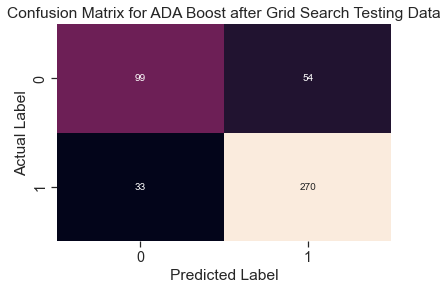

In [145]:
## Confusion matrix on the testing data based on best estimator
models_names={adbgs:'ADA Boost after Grid Search'}

print('Accuracy for {} is'.format(models_names[adbgs]),'\n\n',accuracy_score(test_labels,adbgstest_predict_grid))
print('\n')
print('Classification report for {} Testing Data is'.format(models_names[adbgs]),'\n',
      classification_report(test_labels,nbgstest_predict_grid))
print('\n')
sns.heatmap(confusion_matrix(test_labels,adbgstest_predict_grid),annot=True,fmt='d',cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title("Confusion Matrix for {} Testing Data".format(models_names[adbgs]))
plt.show()

AUC for the Training Data: 0.901
AUC for the Test Data: 0.884


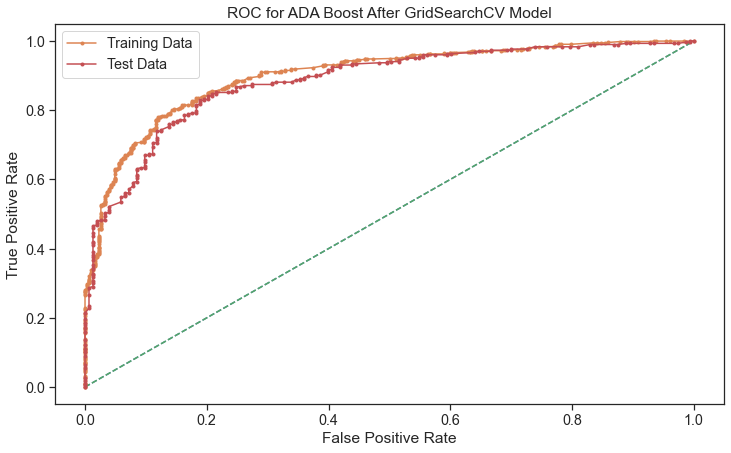

In [146]:
# AUC and ROC for the training data
plt.figure(figsize=(12,7))
# calculate AUC
auc = roc_auc_score(train_labels,adb_best_model.predict_proba(x_train)[:,1])
print('AUC for the Training Data: %.3f' % auc)

#  calculate roc curve
fpr, tpr, thresholds = roc_curve(train_labels,adb_best_model.predict_proba(x_train)[:,1])
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.',label = 'Training Data')

# AUC and ROC for the test data

# calculate AUC
auc = roc_auc_score(test_labels,adb_best_model.predict_proba(x_test)[:,1])
print('AUC for the Test Data: %.3f' % auc)

#  calculate roc curve
fpr, tpr, thresholds = roc_curve(test_labels,adb_best_model.predict_proba(x_test)[:,1])
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.',label='Test Data')
# show the plot
plt.legend(loc='best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for ADA Boost After GridSearchCV Model')
plt.show()

## Gradient Boosting-GridSearch

In [147]:
params={'loss':['deviance', 'exponential'],'n_estimators':[500,1000,1500],'learning_rate':[0.0001,0.001,0.1,10],
        'criterion':['friedman_mse', 'squared_error', 'mse', 'mae']}
gb_grid = GridSearchCV(estimator=gbcl_model, param_grid=params, n_jobs=2, cv=3, verbose=3)

In [148]:
gbgs=gb_grid.fit(x_train,train_labels)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


In [149]:
print(gbgs.best_params_)
print('\n')
print(gbgs.best_estimator_)

{'criterion': 'friedman_mse', 'learning_rate': 0.001, 'loss': 'deviance', 'n_estimators': 1500}


GradientBoostingClassifier(learning_rate=0.001, n_estimators=1500,
                           random_state=1)


In [150]:
gb_best_model=gbgs.best_estimator_

In [151]:
gbgstrain_predict_grid=gb_best_model.predict(x_train)
gbgstest_predict_grid=gb_best_model.predict(x_test)

In [152]:
gbgstest_predict_prob_grid=gb_best_model.predict_proba(x_test)
pd.DataFrame(gbgstest_predict_prob_grid).head()

,0,1
0,0.480031,0.519969
1,0.212949,0.787051
2,0.093250,0.906750
3,0.695719,0.304281
4,0.276061,0.723939


Accuracy for Gradient Boosting after Grid Search is 

 0.8463713477851084


Classification report for Gradient Boosting after Grid Search Training Data is 
               precision    recall  f1-score   support

           0       0.83      0.59      0.69       307
           1       0.85      0.95      0.90       754

    accuracy                           0.85      1061
   macro avg       0.84      0.77      0.79      1061
weighted avg       0.84      0.85      0.84      1061





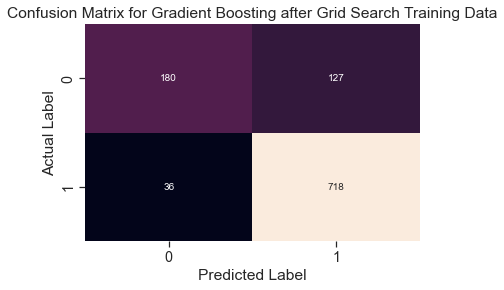

In [153]:
## Confusion matrix on the training data based on best estimator
models_names={gbgs:'Gradient Boosting after Grid Search'}

print('Accuracy for {} is'.format(models_names[gbgs]),'\n\n',accuracy_score(train_labels,gbgstrain_predict_grid))
print('\n')
print('Classification report for {} Training Data is'.format(models_names[gbgs]),'\n',
      classification_report(train_labels,gbgstrain_predict_grid))
print('\n')
sns.heatmap(confusion_matrix(train_labels,gbgstrain_predict_grid),annot=True,fmt='d',cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title("Confusion Matrix for {} Training Data".format(models_names[gbgs]))
plt.show()

Accuracy for Gradient Boosting after Grid Search is 

 0.8223684210526315


Classification report for Gradient Boosting after Grid Search Testing Data is 
               precision    recall  f1-score   support

           0       0.88      0.54      0.67       153
           1       0.81      0.96      0.88       303

    accuracy                           0.82       456
   macro avg       0.84      0.75      0.78       456
weighted avg       0.83      0.82      0.81       456





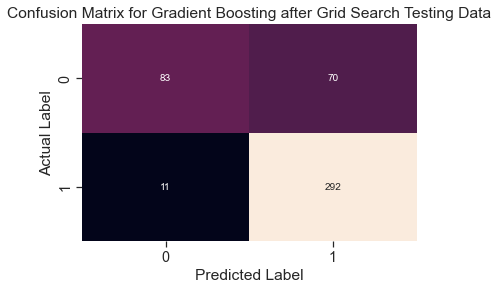

In [154]:
## Confusion matrix on the testing data based on best estimator
models_names={gbgs:'Gradient Boosting after Grid Search'}

print('Accuracy for {} is'.format(models_names[gbgs]),'\n\n',accuracy_score(test_labels,gbgstest_predict_grid))
print('\n')
print('Classification report for {} Testing Data is'.format(models_names[gbgs]),'\n',
      classification_report(test_labels,gbgstest_predict_grid))
print('\n')
sns.heatmap(confusion_matrix(test_labels,gbgstest_predict_grid),annot=True,fmt='d',cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title("Confusion Matrix for {} Testing Data".format(models_names[gbgs]))
plt.show()

AUC for the Training Data: 0.912
AUC for the Test Data: 0.896


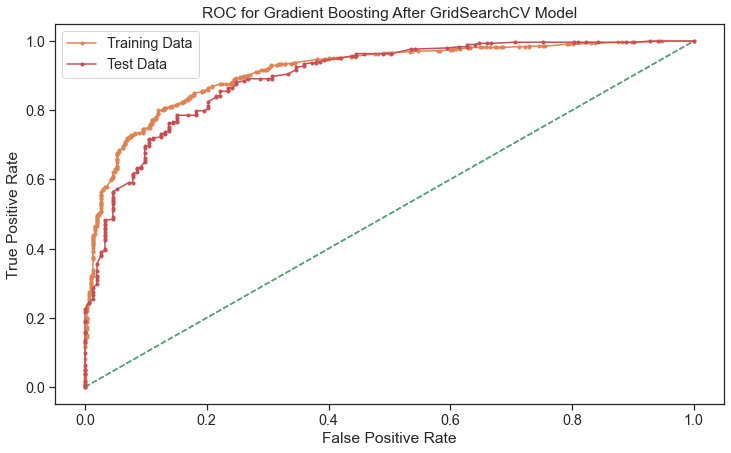

In [155]:
# AUC and ROC for the training data
plt.figure(figsize=(12,7))
# calculate AUC
auc = roc_auc_score(train_labels,gb_best_model.predict_proba(x_train)[:,1])
print('AUC for the Training Data: %.3f' % auc)

#  calculate roc curve
fpr, tpr, thresholds = roc_curve(train_labels,gb_best_model.predict_proba(x_train)[:,1])
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.',label = 'Training Data')

# AUC and ROC for the test data

# calculate AUC
auc = roc_auc_score(test_labels,gb_best_model.predict_proba(x_test)[:,1])
print('AUC for the Test Data: %.3f' % auc)

#  calculate roc curve
fpr, tpr, thresholds = roc_curve(test_labels,gb_best_model.predict_proba(x_test)[:,1])
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.',label='Test Data')
# show the plot
plt.legend(loc='best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Gradient Boosting After GridSearchCV Model')
plt.show()

## Extreme Gradient Boosting-GridSearch

In [156]:
params={'C':[0.1,1,10,100,1000],'gamma':[1,0.1,0.01,0.001,0.0001],'kernel':['rbf']}
xgb_grid = GridSearchCV(estimator=xgb_model, param_grid=params, n_jobs=2, cv=3, verbose=3)

In [157]:
xgbgs=xgb_grid.fit(x_train,train_labels)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[16:06:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "C", "kernel" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:06:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [158]:
print(xgbgs.best_params_)
print('\n')
print(xgbgs.best_estimator_)

{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}


XGBClassifier(C=0.1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=1, gpu_id=-1, importance_type=None,
              interaction_constraints='', kernel='rbf',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)


In [159]:
xgbgs_best_model=xgbgs.best_estimator_

In [160]:
xgbgstrain_predict_grid=xgbgs_best_model.predict(x_train)
xgbgstest_predict_grid=xgbgs_best_model.predict(x_test)

In [161]:
xgbgstest_predict_prob_grid=xgbgs_best_model.predict_proba(x_test)
pd.DataFrame(xgbgstest_predict_prob_grid).head()

,0,1
0,0.728667,0.271333
1,0.348795,0.651205
2,0.004275,0.995725
3,0.819744,0.180256
4,0.033044,0.966956


Accuracy for Extreme Gradient Boosting after Grid Search is 

 0.9255419415645617


Classification report for Extreme Gradient Boosting after Grid Search Training Data is 
               precision    recall  f1-score   support

           0       0.89      0.84      0.87       307
           1       0.94      0.96      0.95       754

    accuracy                           0.93      1061
   macro avg       0.92      0.90      0.91      1061
weighted avg       0.92      0.93      0.92      1061





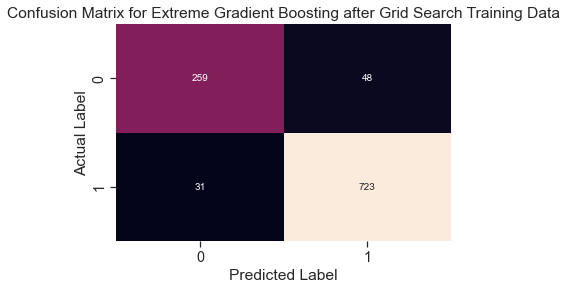

In [162]:
## Confusion matrix on the training data based on best estimator
models_names={xgbgs:'Extreme Gradient Boosting after Grid Search'}

print('Accuracy for {} is'.format(models_names[xgbgs]),'\n\n',accuracy_score(train_labels,xgbgstrain_predict_grid))
print('\n')
print('Classification report for {} Training Data is'.format(models_names[xgbgs]),'\n',
      classification_report(train_labels,xgbgstrain_predict_grid))
print('\n')
sns.heatmap(confusion_matrix(train_labels,xgbgstrain_predict_grid),annot=True,fmt='d',cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title("Confusion Matrix for {} Training Data".format(models_names[xgbgs]))
plt.show()

Accuracy for Extreme Gradient Boosting after Grid Search is 

 0.8267543859649122


Classification report for Extreme Gradient Boosting after Grid Search Testing Data is 
               precision    recall  f1-score   support

           0       0.76      0.71      0.73       153
           1       0.86      0.89      0.87       303

    accuracy                           0.83       456
   macro avg       0.81      0.80      0.80       456
weighted avg       0.82      0.83      0.83       456





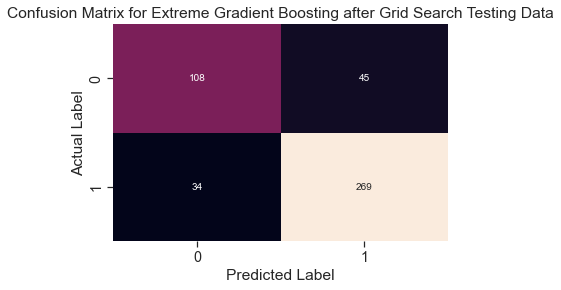

In [163]:
## Confusion matrix on the testing data based on best estimator
models_names={xgbgs:'Extreme Gradient Boosting after Grid Search'}

print('Accuracy for {} is'.format(models_names[xgbgs]),'\n\n',accuracy_score(test_labels,xgbgstest_predict_grid))
print('\n')
print('Classification report for {} Testing Data is'.format(models_names[xgbgs]),'\n',
      classification_report(test_labels,xgbgstest_predict_grid))
print('\n')
sns.heatmap(confusion_matrix(test_labels,xgbgstest_predict_grid),annot=True,fmt='d',cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title("Confusion Matrix for {} Testing Data".format(models_names[xgbgs]))
plt.show()

AUC for the Training Data: 0.977
AUC for the Test Data: 0.900


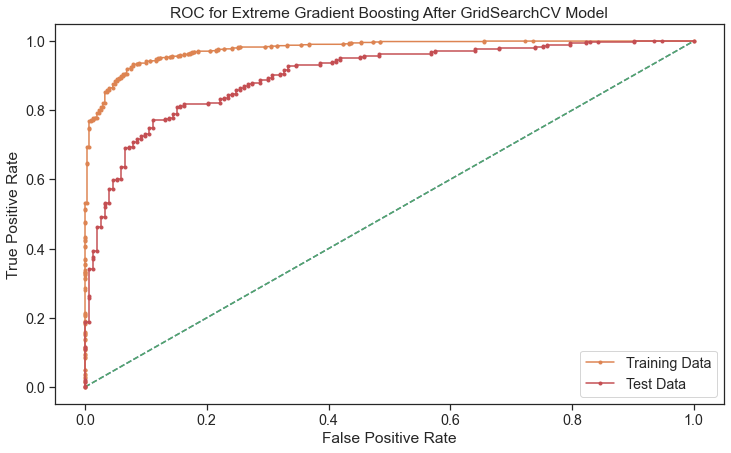

In [164]:
# AUC and ROC for the training data
plt.figure(figsize=(12,7))
# calculate AUC
auc = roc_auc_score(train_labels,xgbgs_best_model.predict_proba(x_train)[:,1])
print('AUC for the Training Data: %.3f' % auc)

#  calculate roc curve
fpr, tpr, thresholds = roc_curve(train_labels,xgbgs_best_model.predict_proba(x_train)[:,1])
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.',label = 'Training Data')

# AUC and ROC for the test data

# calculate AUC
auc = roc_auc_score(test_labels,xgbgs_best_model.predict_proba(x_test)[:,1])
print('AUC for the Test Data: %.3f' % auc)

#  calculate roc curve
fpr, tpr, thresholds = roc_curve(test_labels,xgbgs_best_model.predict_proba(x_test)[:,1])
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.',label='Test Data')
# show the plot
plt.legend(loc='best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Extreme Gradient Boosting After GridSearchCV Model')
plt.show()

## Random Forest-Grid Search

In [165]:
params={'criterion':['gini', 'entropy'],'n_estimators':[100,200,300],'max_features':['auto','sqrt','log2'],
        'bootstrap':[True,False], 'max_samples':[0.5,1]}
rf_grid = GridSearchCV(estimator=RF_model, param_grid=params, n_jobs=2, cv=3, verbose=3)

In [166]:
rfgs=rf_grid.fit(x_train,train_labels)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


In [167]:
print(rfgs.best_params_)
print('\n')
print(rfgs.best_estimator_)

{'bootstrap': True, 'criterion': 'entropy', 'max_features': 'auto', 'max_samples': 0.5, 'n_estimators': 300}


RandomForestClassifier(criterion='entropy', max_samples=0.5, n_estimators=300,
                       random_state=1)


In [168]:
rfgs_best_model=rfgs.best_estimator_

In [169]:
rfgstrain_predict_grid=rfgs_best_model.predict(x_train)
rfgstest_predict_grid=rfgs_best_model.predict(x_test)

In [170]:
rfgstest_predict_prob_grid=rfgs_best_model.predict_proba(x_test)
pd.DataFrame(rfgstest_predict_prob_grid).head()

,0,1
0,0.730000,0.270000
1,0.276667,0.723333
2,0.053333,0.946667
3,0.760000,0.240000
4,0.103333,0.896667


Accuracy for Bagging (Random forest) after Grid Search is 

 0.9670122525918945


Classification report for Bagging (Random forest) after Grid Search Training Data is 
               precision    recall  f1-score   support

           0       0.99      0.90      0.94       307
           1       0.96      0.99      0.98       754

    accuracy                           0.97      1061
   macro avg       0.97      0.95      0.96      1061
weighted avg       0.97      0.97      0.97      1061





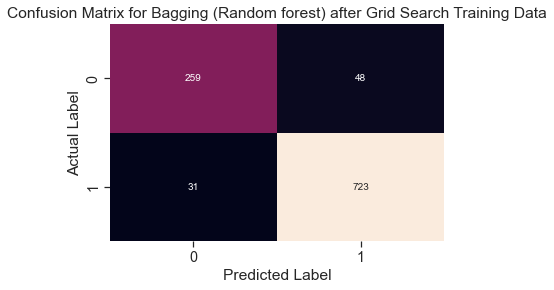

In [171]:
## Confusion matrix on the training data based on best estimator
models_names={rfgs:'Bagging (Random forest) after Grid Search'}

print('Accuracy for {} is'.format(models_names[rfgs]),'\n\n',accuracy_score(train_labels,rfgstrain_predict_grid))
print('\n')
print('Classification report for {} Training Data is'.format(models_names[rfgs]),'\n',
      classification_report(train_labels,rfgstrain_predict_grid))
print('\n')
sns.heatmap(confusion_matrix(train_labels,xgbgstrain_predict_grid),annot=True,fmt='d',cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title("Confusion Matrix for {} Training Data".format(models_names[rfgs]))
plt.show()

Accuracy for Bagging (Random forest) after Grid Search is 

 0.8267543859649122


Classification report for Bagging (Random forest) after Grid Search Testing Data is 
               precision    recall  f1-score   support

           0       0.77      0.69      0.73       153
           1       0.85      0.90      0.87       303

    accuracy                           0.83       456
   macro avg       0.81      0.79      0.80       456
weighted avg       0.82      0.83      0.82       456





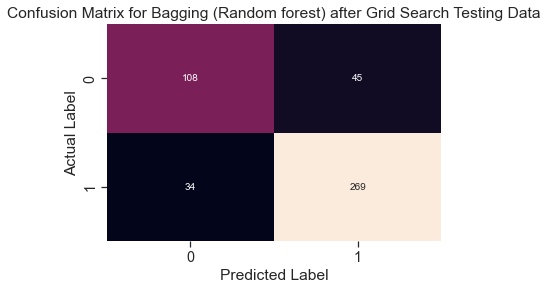

In [172]:
## Confusion matrix on the testing data based on best estimator
models_names={rfgs:'Bagging (Random forest) after Grid Search'}

print('Accuracy for {} is'.format(models_names[rfgs]),'\n\n',accuracy_score(test_labels,rfgstest_predict_grid))
print('\n')
print('Classification report for {} Testing Data is'.format(models_names[rfgs]),'\n',
      classification_report(test_labels,rfgstest_predict_grid))
print('\n')
sns.heatmap(confusion_matrix(test_labels,xgbgstest_predict_grid),annot=True,fmt='d',cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title("Confusion Matrix for {} Testing Data".format(models_names[rfgs]))
plt.show()

AUC for the Training Data: 0.996
AUC for the Test Data: 0.896


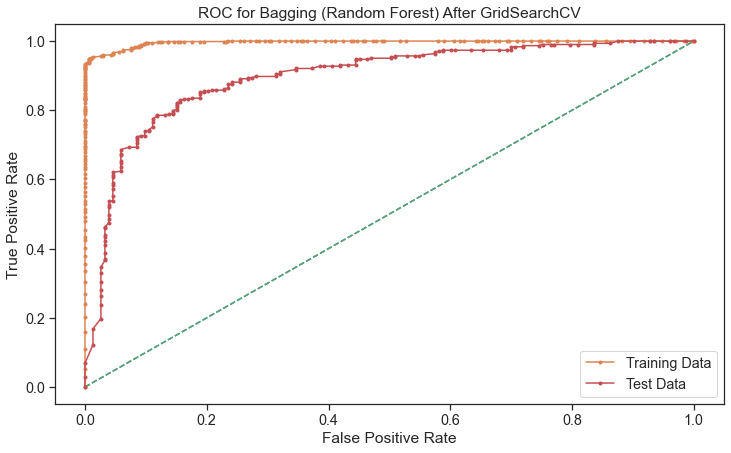

In [173]:
# AUC and ROC for the training data
plt.figure(figsize=(12,7))
# calculate AUC
auc = roc_auc_score(train_labels,rfgs_best_model.predict_proba(x_train)[:,1])
print('AUC for the Training Data: %.3f' % auc)

#  calculate roc curve
fpr, tpr, thresholds = roc_curve(train_labels,rfgs_best_model.predict_proba(x_train)[:,1])
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.',label = 'Training Data')

# AUC and ROC for the test data

# calculate AUC
auc = roc_auc_score(test_labels,rfgs_best_model.predict_proba(x_test)[:,1])
print('AUC for the Test Data: %.3f' % auc)

#  calculate roc curve
fpr, tpr, thresholds = roc_curve(test_labels,rfgs_best_model.predict_proba(x_test)[:,1])
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.',label='Test Data')
# show the plot
plt.legend(loc='best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Bagging (Random Forest) After GridSearchCV')
plt.show()

In [174]:
index = ['1941-Roosevelt','1961-Kennedy','1973-Nixon']
inaugural_speech=pd.DataFrame({'president':['Roosevelt - 1941','Kennedy - 1961','Nixon - 1973'],
                               'text':[inaugural.raw('1941-Roosevelt.txt'),
                                       inaugural.raw('1961-Kennedy.txt'),
                                       inaugural.raw('1973-Nixon.txt')]},index=index)
inaugural_speech

,president,text
1941-Roosevelt,Roosevelt - 1941,On each national day of inauguration since 178...
1961-Kennedy,Kennedy - 1961,"Vice President Johnson, Mr. Speaker, Mr. Chief..."
1973-Nixon,Nixon - 1973,"Mr. Vice President, Mr. Speaker, Mr. Chief Jus..."


In [175]:
inaugural_speech['char_count'] = inaugural_speech['text'].str.len() ## this also includes spaces
inaugural_speech

,president,text,char_count
1941-Roosevelt,Roosevelt - 1941,On each national day of inauguration since 178...,7571
1961-Kennedy,Kennedy - 1961,"Vice President Johnson, Mr. Speaker, Mr. Chief...",7618
1973-Nixon,Nixon - 1973,"Mr. Vice President, Mr. Speaker, Mr. Chief Jus...",9991


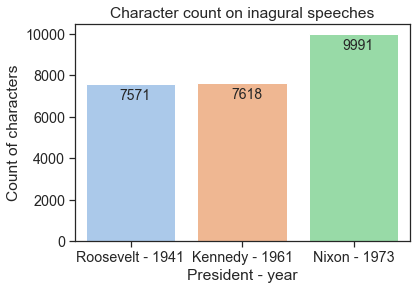

In [176]:
plt.figure(figsize=(6,4))
ax = sns.barplot(y='char_count', x='president', data=inaugural_speech, palette = 'pastel')
plt.title('Character count on inaugural speeches')
plt.xlabel('President - year')
plt.ylabel('Count of characters')
for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_height()),
                    (p.get_x()+.3,
                     p.get_height()-750), fontsize = 14)

In [177]:
inaugural_speech['word_count'] = inaugural_speech['text'].apply(lambda x: len(str(x).split(" ")))
inaugural_speech

,president,text,char_count,word_count
1941-Roosevelt,Roosevelt - 1941,On each national day of inauguration since 178...,7571,1323
1961-Kennedy,Kennedy - 1961,"Vice President Johnson, Mr. Speaker, Mr. Chief...",7618,1364
1973-Nixon,Nixon - 1973,"Mr. Vice President, Mr. Speaker, Mr. Chief Jus...",9991,1769


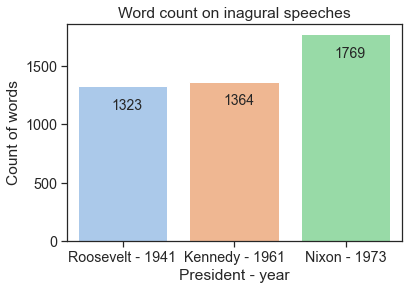

In [178]:
plt.figure(figsize=(6,4))
ax = sns.barplot(y='word_count', x='president', data=inaugural_speech, palette = 'pastel')
plt.title('Word count on inaugural speeches')
plt.xlabel('President - year')
plt.ylabel('Count of words')
for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_height()),
                    (p.get_x()+.3,
                     p.get_height()-200), fontsize = 14)

In [179]:
inaugural_speech['sents_count'] = inaugural_speech['text'].apply(lambda x: len(sent_tokenize(x)))
inaugural_speech

,president,text,char_count,word_count,sents_count
1941-Roosevelt,Roosevelt - 1941,On each national day of inauguration since 178...,7571,1323,68
1961-Kennedy,Kennedy - 1961,"Vice President Johnson, Mr. Speaker, Mr. Chief...",7618,1364,52
1973-Nixon,Nixon - 1973,"Mr. Vice President, Mr. Speaker, Mr. Chief Jus...",9991,1769,68


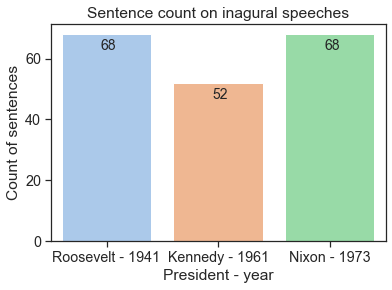

In [180]:
plt.figure(figsize=(6,4))
ax = sns.barplot(y='sents_count', x='president', data=inaugural_speech, palette = 'pastel')
plt.title('Sentence count on inaugural speeches')
plt.xlabel('President - year')
plt.ylabel('Count of sentences')
for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_height()),
                    (p.get_x()+.35,
                     p.get_height()-5), fontsize = 14)

In [181]:
# Lower case conversion for all words
inaugural_speech['text'] = inaugural_speech['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
inaugural_speech['text']

1941-Roosevelt    on each national day of inauguration since 178...
1961-Kennedy      vice president johnson, mr. speaker, mr. chief...
1973-Nixon        mr. vice president, mr. speaker, mr. chief jus...
Name: text, dtype: object

In [182]:
# Remove punctuation
inaugural_speech['text'] = inaugural_speech['text'].str.replace('[^\w\s]','')
inaugural_speech['text']

1941-Roosevelt    on each national day of inauguration since 178...
1961-Kennedy      vice president johnson mr speaker mr chief jus...
1973-Nixon        mr vice president mr speaker mr chief justice ...
Name: text, dtype: object

In [183]:
stop_words = stopwords.words('english')
add_to_stop_words = ['mr','on','it','the','in','let','to','us','shall'] #add these to the stop words
stop_words.extend(add_to_stop_words)
stop_words=set(stop_words)

In [184]:
# remove the stop words from the three speeches
inaugural_speech['text'] = inaugural_speech['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))
inaugural_speech

,president,text,char_count,word_count,sents_count
1941-Roosevelt,Roosevelt - 1941,national day inauguration since 1789 people re...,7571,1323,68
1961-Kennedy,Kennedy - 1961,vice president johnson speaker chief justice p...,7618,1364,52
1973-Nixon,Nixon - 1973,vice president speaker chief justice senator c...,9991,1769,68


In [185]:
list(inaugural_speech[inaugural_speech['president']=="Roosevelt - 1941"].text)

['national day inauguration since 1789 people renewed sense dedication united states washingtons day task people create weld together nation lincolns day task people preserve nation disruption within day task people save nation institutions disruption without come time midst swift happenings pause moment take stock recall place history rediscover may risk real peril inaction lives nations determined count years lifetime human spirit life man threescore years ten little little less life nation fullness measure live men doubt men believe democracy form government frame life limited measured kind mystical artificial fate unexplained reason tyranny slavery become surging wave future freedom ebbing tide americans know true eight years ago life republic seemed frozen fatalistic terror proved true midst shock acted acted quickly boldly decisively later years living years fruitful years people democracy brought greater security hope better understanding lifes ideals measured material things vi

In [186]:
list(inaugural_speech[inaugural_speech['president']=="Kennedy - 1961"].text)

['vice president johnson speaker chief justice president eisenhower vice president nixon president truman reverend clergy fellow citizens observe today victory party celebration freedom symbolizing end well beginning signifying renewal well change sworn almighty god solemn oath forebears l prescribed nearly century three quarters ago world different man holds mortal hands power abolish forms human poverty forms human life yet revolutionary beliefs forebears fought still issue around globe belief rights man come generosity state hand god dare forget today heirs first revolution word go forth time place friend foe alike torch passed new generation americans born century tempered war disciplined hard bitter peace proud ancient heritage unwilling witness permit slow undoing human rights nation always committed committed today home around world every nation know whether wishes well ill pay price bear burden meet hardship support friend oppose foe order assure survival success liberty much p

In [187]:
list(inaugural_speech[inaugural_speech['president']=="Nixon - 1973"].text)

['vice president speaker chief justice senator cook mrs eisenhower fellow citizens great good country share together met four years ago america bleak spirit depressed prospect seemingly endless war abroad destructive conflict home meet today stand threshold new era peace world central question use peace resolve era enter postwar periods often time retreat isolation leads stagnation home invites new danger abroad resolve become time great responsibilities greatly borne renew spirit promise america enter third century nation past year saw farreaching results new policies peace continuing revitalize traditional friendships missions peking moscow able establish base new durable pattern relationships among nations world americas bold initiatives 1972 long remembered year greatest progress since end world war ii toward lasting peace world peace seek world flimsy peace merely interlude wars peace endure generations come important understand necessity limitations americas role maintaining peac

In [188]:
freq = pd.Series(' '.join(inaugural_speech.iloc[0:1,1]).split()).value_counts()[:3]
freq

nation    11
know      10
spirit     9
dtype: int64

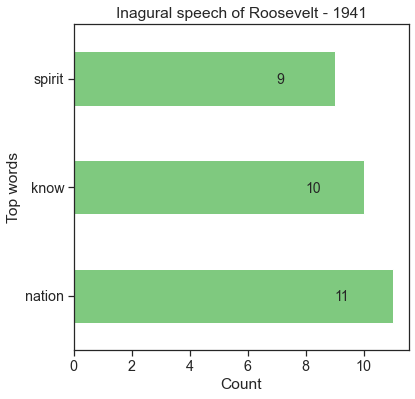

In [189]:
#plot top three words and their counts
plt.figure(figsize=(6,6))
ax = freq.plot(kind='barh', colormap = 'Accent')
plt.title('Inaugural speech of Roosevelt - 1941')
plt.xlabel('Count')
plt.ylabel('Top words')
for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_width()),
                    (p.get_width()-2, p.get_y()+.20), fontsize=14)

In [190]:
# Use pd.series and value counts to get top three words
freq = pd.Series(' '.join(inaugural_speech.iloc[1:2,1]).split()).value_counts()[:3]
freq

world    8
sides    8
new      7
dtype: int64

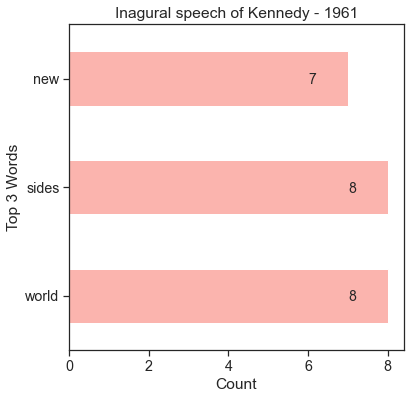

In [191]:
#plot top three words and their counts
plt.figure(figsize=(6,6))
ax = freq.plot(kind='barh', colormap = 'Pastel1')
plt.title('Inaugural speech of Kennedy - 1961')
plt.xlabel('Count')
plt.ylabel('Top 3 Words')
for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_width()),
                    (p.get_width()-1, p.get_y()+.20), fontsize=14)

In [192]:
# Use pd.series and value counts to get top three words
freq = pd.Series(' '.join(inaugural_speech.iloc[2:3,1]).split()).value_counts()[:3]
freq

peace    19
world    16
new      15
dtype: int64

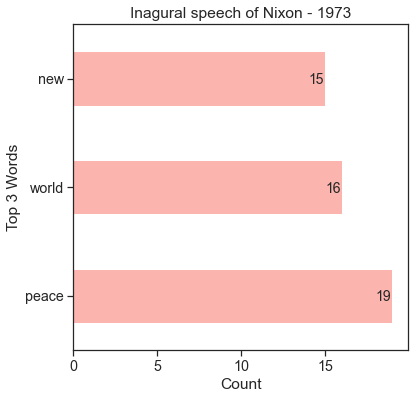

In [193]:
plt.figure(figsize=(6,6))
ax = freq.plot(kind='barh', colormap = 'Pastel1')
plt.title('Inaugural speech of Nixon - 1973')
plt.xlabel('Count')
plt.ylabel('Top 3 Words')
for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_width()),
                    (p.get_width()-1, p.get_y()+.20), fontsize=14)

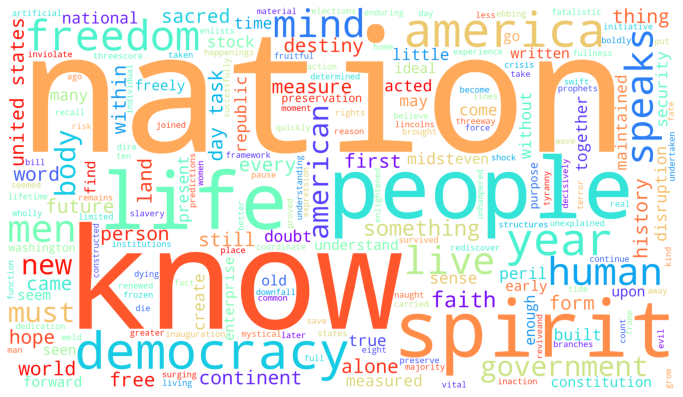

In [194]:
#import word cloud library and plot the word cloud for each speech
from wordcloud import WordCloud,STOPWORDS
words = ' '.join(inaugural_speech.iloc[0:1,1])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      colormap = 'rainbow',
                      width=3500,
                      height=2000
                     ).generate(words)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

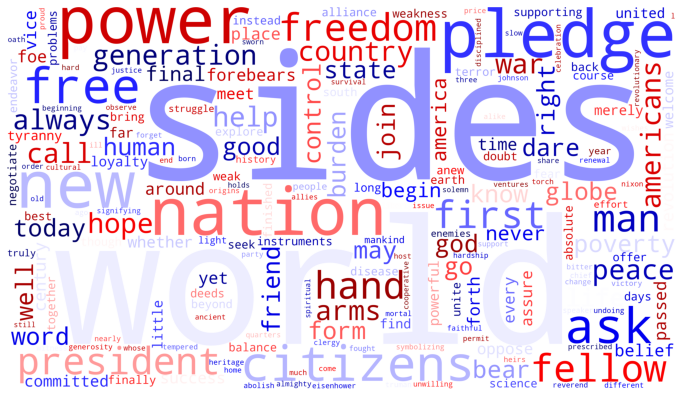

In [195]:
words = ' '.join(inaugural_speech.iloc[1:2,1])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      colormap = 'seismic_r',
                      width=3500,
                      height=2000
                     ).generate(words)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

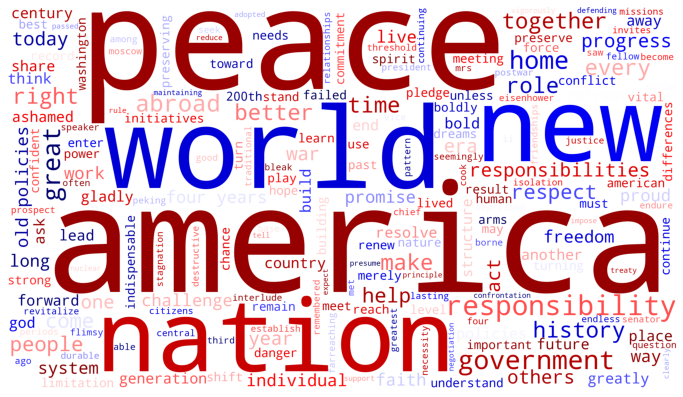

In [196]:
words = ' '.join(inaugural_speech.iloc[2:3,1])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      colormap = 'seismic_r',
                      width=3500,
                      height=2000
                     ).generate(words)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()